#### Imports:

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mofapy2.run.entry_point import entry_point
import mofax 
import requests
import umap
import hdbscan
from matplotlib.lines import Line2D
import urllib.request
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from snf import snf


C:\Users\nicki\AppData\Roaming\Python\Python312\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [ ]:
def calculate_tfidf_and_similarity(df, view_name):
    print(f"\n--- Elaborazione Vista: {view_name} ---")
    n_genes = df.shape[0]
    
    doc_freq = df.sum(axis=0) 
    
    idf = np.log(n_genes / doc_freq + 1e-10)
    
    weighted_matrix = df.values * np.sqrt(idf.values)
    
    weighted_intersection = np.dot(weighted_matrix, weighted_matrix.T)
    
    gene_sums = (df * idf).sum(axis=1).values
    
    weighted_union = gene_sums[:, None] + gene_sums[None, :] - weighted_intersection
    
    with np.errstate(divide='ignore', invalid='ignore'):
        similarity = weighted_intersection / weighted_union
        similarity[np.isnan(similarity)] = 0.0
    
    np.fill_diagonal(similarity, 1.0)
    
    sim_df = pd.DataFrame(similarity, index=df.index, columns=df.index)
    
    print(f"   Matrice completata: {sim_df.shape}")
    return sim_df

input_files = {
    "BP": "filtered_BP.csv",
    "CC": "filtered_CC.csv",
    "MF": "filtered_MF.csv",
    "HPO": "filtered_HPO.csv" 
}

similarity_results = {}

for key, filename in input_files.items():
    if os.path.exists(filename):
        # Carica dati
        df = pd.read_csv(filename, index_col=0)
        
        # Calcola
        sim_matrix = calculate_tfidf_and_similarity(df, key)
        
        # Salva
        output_file = f"similarity_{key}.csv"
        sim_matrix.to_csv(output_file)
        print(f"   -> Salvato in: {output_file}")
        
        similarity_results[key] = sim_matrix
    else:
        print(f"ATTENZIONE: File {filename} non trovato. Hai eseguito la Fase 1?")

print("\nFase 2 Completata.")

### STARTING CODE

In [ ]:
obo_files = {
    "GO": {"url": "https://current.geneontology.org/ontology/go-basic.obo", "path": "go-basic.obo"},
    "HPO": {"url": "https://raw.githubusercontent.com/obophenotype/human-phenotype-ontology/master/hp.obo", "path": "hp.obo"}
}

data_files = {
    "BP": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_go_matrix_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_go_matrix_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_go_matrix_propT_rel-is_a-part_of_ont-MF.csv",
    "HPO": r"C:\Users\husse\Desktop\Uni\ScientificVisualization\csv_data\gene_hpo_matrix_binary_withAncestors_namespace_Phenotypic_abnormality.csv"
}

depth_files = {
    "BP": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-BP.csv",
    "CC": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-CC.csv",
    "MF": "./csv_data/goterm_depth_propT_rel-is_a-part_of_ont-MF.csv"
}

def check_and_download(url, filename):
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url, filename)
        except Exception as e:
            print(e)

for key, info in obo_files.items():
    check_and_download(info["url"], info["path"])


def load_ontology(obo_path):
    try:
        return GODag(obo_path)
    except Exception as e:
        print(e)
        return None

def normalize_id(term_id):
    term_id = str(term_id)
    if "GO" in term_id or "HP" in term_id:
        return term_id.replace(".", ":").replace("_", ":")
    return term_id

def filter_by_depth(df, depth_file, min_depth=4):
    
    try:
        df_depth = pd.read_csv(depth_file, index_col=0, nrows=1)
        depth_series = pd.to_numeric(df_depth.iloc[0], errors='coerce').dropna()
        valid_terms = set(depth_series[depth_series >= min_depth].index)
        
        cols_to_keep = []
        for col in df.columns:
            if col in valid_terms or normalize_id(col) in valid_terms:
                cols_to_keep.append(col)
                
        return df[cols_to_keep]
    except Exception as e:
        print(e)
        return df

def frequency_filtering(df, min_genes=3, max_pct=0.20):
    counts = df.sum(axis=0)
    limit = df.shape[0] * max_pct
    mask = (counts >= min_genes) & (counts <= limit)
    df_filtered = df.loc[:, mask]
    return df_filtered

def remove_semantic_redundancy(df, dag, threshold=0.7):

    example_col = df.columns[0]
    normalized_ex = normalize_id(example_col)
    if normalized_ex not in dag:
        print(f"Il termine '{example_col}' (norm: '{normalized_ex}') non è stato trovato nel DAG!")


    matrix = (df.values > 0).astype(int).T
    intersect = matrix @ matrix.T
    row_sums = matrix.sum(axis=1)
    union = row_sums[:, None] + row_sums[None, :] - intersect
    
    with np.errstate(divide='ignore', invalid='ignore'):
        sim_matrix = np.triu(intersect / union, k=1)

    pairs = np.where(sim_matrix >= threshold)
    to_drop = set()
    cols = df.columns
    
    match_count = 0
    
    for i, j in zip(*pairs):
        term_a_raw = cols[i]
        term_b_raw = cols[j]
        
        term_a = normalize_id(term_a_raw)
        term_b = normalize_id(term_b_raw)
        
        if term_a in dag and term_b in dag:
            match_count += 1
            parents_b = dag[term_b].get_all_parents()
            parents_a = dag[term_a].get_all_parents()
            
            if term_a in parents_b:
                to_drop.add(term_a_raw)
            elif term_b in parents_a:
                to_drop.add(term_b_raw)
            
    return df.drop(columns=list(to_drop))

def keep_common_active_genes(dfs_dict):
    print("--- Filtro Geni Comuni Attivi ---")
    
    # 1. Trova i geni che hanno almeno un valore != 0 in OGNI vista
    valid_genes_per_view = []
    
    for name, df in dfs_dict.items():
        # Calcola la somma per riga (gene)
        row_sums = df.sum(axis=1)
        # Tieni solo i geni con somma > 0
        active_genes = set(row_sums[row_sums > 0].index)
        valid_genes_per_view.append(active_genes)
        print(f"   Vista {name}: {len(active_genes)} geni attivi su {len(df)}")

    common_genes = set.intersection(*valid_genes_per_view)
    common_genes = sorted(list(common_genes))
    
    print(f"   -> Geni validi comuni rimasti: {len(common_genes)}")
    
    filtered_dict = {}
    for name, df in dfs_dict.items():
        # .loc seleziona solo le righe dei geni comuni
        filtered_dict[name] = df.loc[common_genes]
        
    return filtered_dict

go_dag = load_ontology(obo_files["GO"]["path"])
hpo_dag = load_ontology(obo_files["HPO"]["path"])

processed_dfs = {}

for key, path in data_files.items():
    try:
        df = pd.read_csv(path, index_col=0)
        
        if key in depth_files:
            df = filter_by_depth(df, depth_files[key], min_depth=4)
        df = frequency_filtering(df)
        
        current_dag = hpo_dag if key == "HPO" else go_dag
        
        df = remove_semantic_redundancy(df, current_dag, threshold=0.7)
        
        processed_dfs[key] = df
        
    except FileNotFoundError:
        print(f"File non trovato: {path}")

if processed_dfs:
    final_dfs = keep_common_active_genes(processed_dfs)
    print("\n=== Salvataggio ===")
    for key, df in final_dfs.items():
        out_name = f"filtered_final_{key}.csv"
        df.to_csv(out_name)
        print(f"   -> {key}: {df.shape} salvato in {out_name}")

In [ ]:
input_files = {
    "BP": "filtered_final_BP.csv",
    "CC": "filtered_final_CC.csv",
    "MF": "filtered_final_MF.csv",
    "HPO": "filtered_final_HPO.csv"
}

def process_phase2(file_path, view_name):
    print(f"\n--- Elaborazione Vista: {view_name} ---")
    
    # 1. Caricamento Dati (Matrice Binaria)
    try:
        df_binary = pd.read_csv(file_path, index_col=0)
    except FileNotFoundError:
        print(f"   ERRORE: File {file_path} non trovato")
        return

    tfidf_transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
    
    tfidf_matrix_sparse = tfidf_transformer.fit_transform(df_binary)
    
    df_tfidf = pd.DataFrame(
        tfidf_matrix_sparse.toarray(), 
        index=df_binary.index, 
        columns=df_binary.columns
    )
    print(f"   TF-IDF Calcolato. Range valori: [{df_tfidf.values.min():.4f}, {df_tfidf.values.max():.4f}]")

    # 3. Output per MOFA (Gene x Termini, Pesato)
    mofa_filename = f"mofa_input_{view_name}.csv"
    df_tfidf.to_csv(mofa_filename)

    cosine_sim = cosine_similarity(tfidf_matrix_sparse)
    
    # Ricostruzione DataFrame simmetrico Gene x Gene
    df_sim = pd.DataFrame(
        cosine_sim,
        index=df_binary.index,
        columns=df_binary.index
    )
    
    diag_mean = np.diag(df_sim).mean()
    print(f"   Similarità Calcolata: {df_sim.shape}. Media diagonale: {diag_mean:.2f} (atteso 1.0)")

    snf_filename = f"snf_similarity_{view_name}.csv"
    df_sim.to_csv(snf_filename)

for key, filename in input_files.items():
    process_phase2(filename, key)

In [ ]:
MODEL_OUTPUT_FILE = "C:\\Users\\husse\\Desktop\\Uni\\ScientificVisualization\\mofa_model_final.hdf5"

output_files = {
    "BP": "filtered_final_BP.csv",
    "CC": "filtered_final_CC.csv",
    "MF": "filtered_final_MF.csv",
    "HPO": "filtered_final_HPO.csv"
}

mofa_views = [pd.read_csv(output_files[key], index_col=0) for key in ["BP", "CC", "MF", "HPO"]]

# 1. Initialization
me = entry_point()

# Data preparation
LIKELIHOODS = ['bernoulli', 'bernoulli', 'bernoulli', 'bernoulli']
# The data is nested: [[df_bp], [df_cc], [df_mf], [df_hpo]] to define 4 views with 1 group each.
mofa_views_nested = [[df] for df in mofa_views] 

# 2. Set Data Pre-processing Options (Scaling/Centering)
me.set_data_options(
    scale_views=False,
    scale_groups=False,
    center_groups=True,
    use_float32=False
)

# 3. Set Data and Likelihoods
me.set_data_matrix(
    data=mofa_views_nested,
    likelihoods=LIKELIHOODS,
    views_names=['GO-BP', 'GO-CC', 'GO-MF', 'HPO']
)

# 4. Set Model Parameters
N_FACTORS = 10
me.set_model_options(
    factors=N_FACTORS,
    spikeslab_weights=True,
    ard_weights=True
)


me.set_train_options(
    iter=1000, 
    convergence_mode="fast", 
    gpu_mode=True, #False if no GPU available
    seed=42,
    outfile=MODEL_OUTPUT_FILE
)


me.build()
me.run()

me.save(MODEL_OUTPUT_FILE)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='GO-BP' group='group0' with N=3317 sa

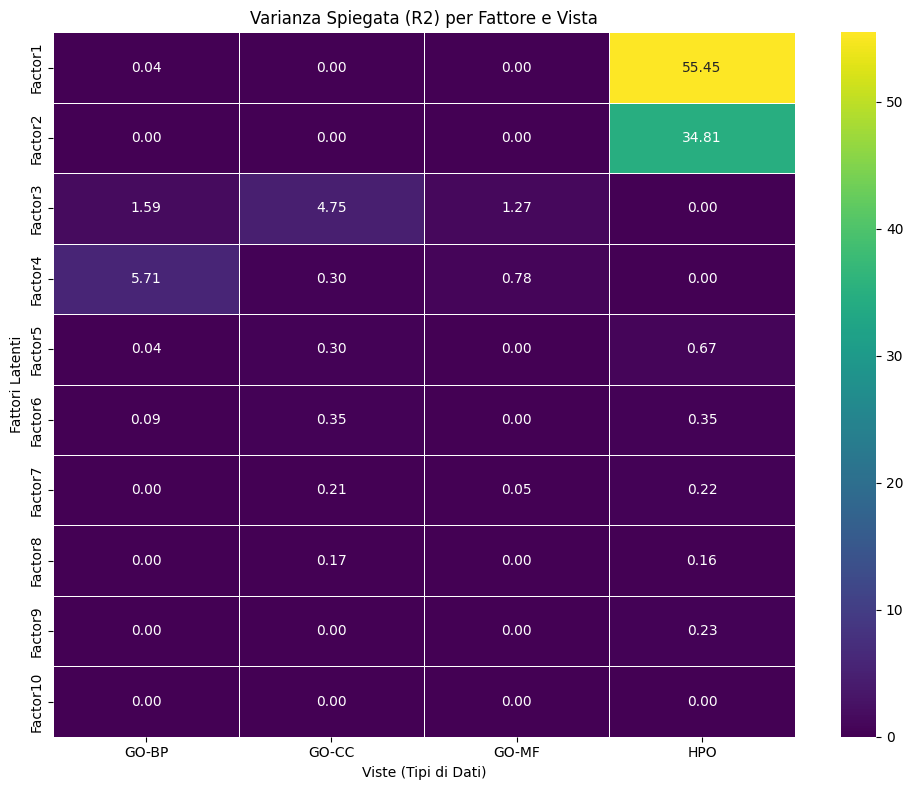

In [5]:
MODEL_OUTPUT_FILE = "C:\\Users\\husse\\Desktop\\Uni\\ScientificVisualization\\mofa_model_final.hdf5"
model = mofax.mofa_model(MODEL_OUTPUT_FILE)

r2_df = model.get_variance_explained()

r2_matrix = r2_df.pivot(index='Factor', columns='View', values='R2')

sorted_index = sorted(r2_matrix.index, key=lambda x: int(x.replace("Factor", "")))
r2_matrix = r2_matrix.reindex(sorted_index)

plt.figure(figsize=(10, 8))
sns.heatmap(
    r2_matrix, 
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=.5
)

plt.title("Varianza Spiegata (R2) per Fattore e Vista")
plt.ylabel("Fattori Latenti")
plt.xlabel("Viste (Tipi di Dati)")
plt.tight_layout()
plt.show()

In [ ]:
# Load Model
model = mofax.mofa_model(MODEL_OUTPUT_FILE)

# File Paths Configuration
file_paths = {
    'GO-BP': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_BP.csv",
    'GO-CC': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_CC.csv", 
    'GO-MF': r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_MF.csv",
    'HPO':   r"C:\Users\nicki\Desktop\magi\Anno 1\Q1\ScientificVisualization\filtered_final_HPO.csv"
}

def get_term_description(term_id):
    
    try:
        # Fetch GO Terms
        if term_id.startswith("GO."):
            term_id = term_id.replace(".", ":")
            url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{term_id}"
            response = requests.get(url, headers={"Accept": "application/json"}, timeout=2)
            if response.status_code == 200:
                return response.json()['results'][0]['name']
        
        # Fetch HPO Terms
        elif term_id.startswith("HP:"):
            url = f"https://ontology.jax.org/api/hp/terms/{term_id}"
            response = requests.get(url, timeout=2)
            if response.status_code == 200:
                return response.json()['name']
                
    except Exception:
        print(f"Error fetching description for {term_id}")
    
    return term_id

def plot_weights_fixed_translated(view_name, factor_index=0, n_top=5):
    # Load Weights
    try:
        w_df = model.get_weights(views=view_name, factors=factor_index, df=True)
    except Exception as e:
        print(f"Error loading weights: {e}")
        return

    # Fix Feature Names from CSV
    try:
        if view_name in file_paths:
            csv_cols = pd.read_csv(file_paths[view_name], index_col=0, nrows=0).columns.tolist()
            
            if len(csv_cols) == len(w_df):
                w_df.index = csv_cols
            else:
                print(f"Warning: Column count mismatch for {view_name}. Using generic IDs.")
    except Exception as e:
        print(f"Error reading CSV: {e}")

    # Process & Sort Top Features
    col_name = None
    for c in w_df.columns:
        if pd.api.types.is_numeric_dtype(w_df[c]):
            col_name = c
            break     
    if col_name is None: return

    w_df['abs_val'] = w_df[col_name].abs()
    top_features = w_df.sort_values('abs_val', ascending=False).head(n_top)

    new_labels = [] 

    for term_id, row in top_features.iterrows():
        desc = get_term_description(term_id)
        weight_val = row[col_name]
        
        short_desc = (desc[:40] + '..') if len(desc) > 40 else desc
        new_labels.append(f"{term_id}\n{short_desc}")

    top_features.index = new_labels

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.barplot(
        data=top_features,
        x=col_name,
        y=top_features.index,
        palette="viridis"
    )
    
    plt.title(f"Top {n_top} Features - {view_name} - Factor {factor_index+1}")
    plt.xlabel("Weight")
    plt.ylabel("")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

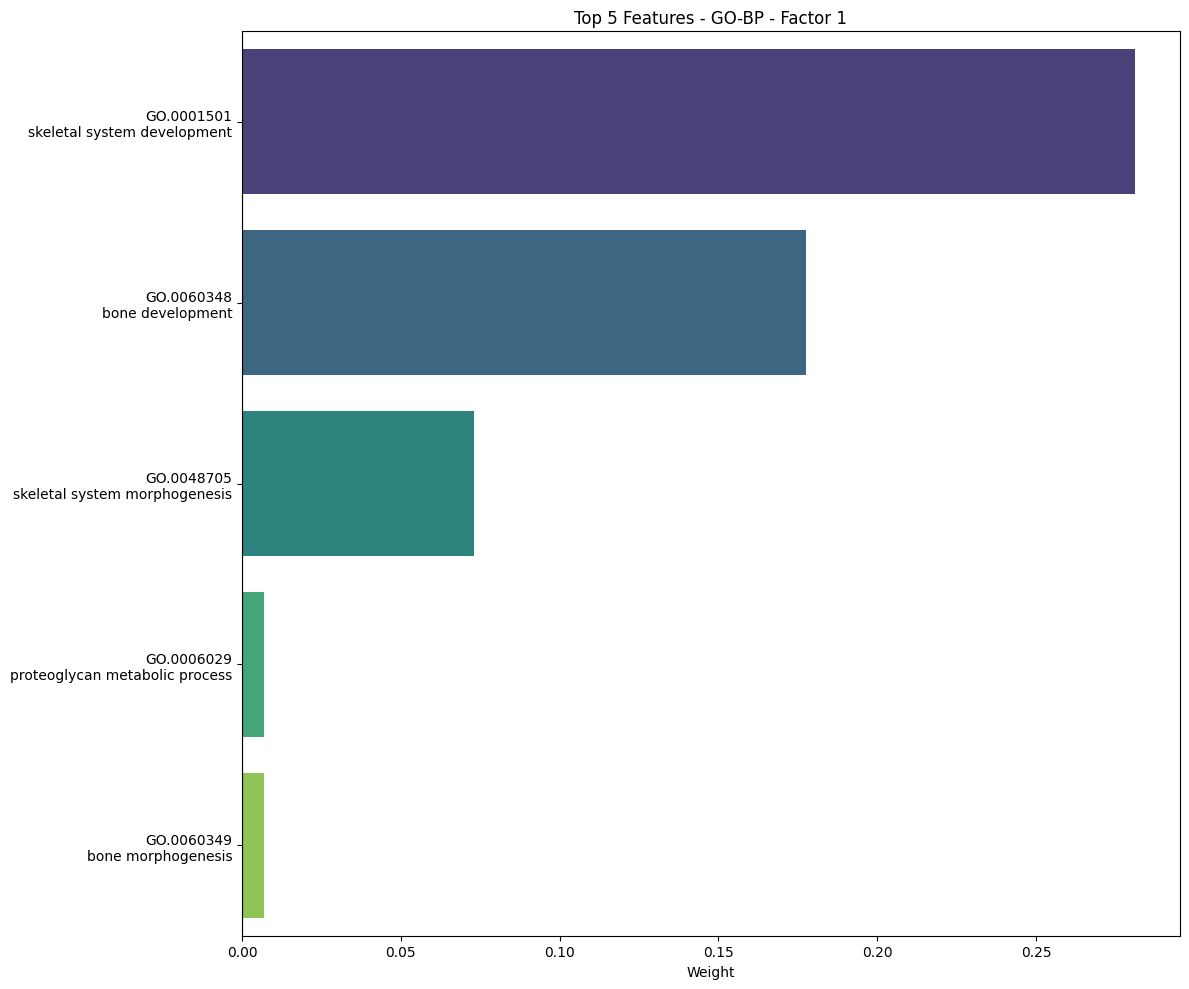

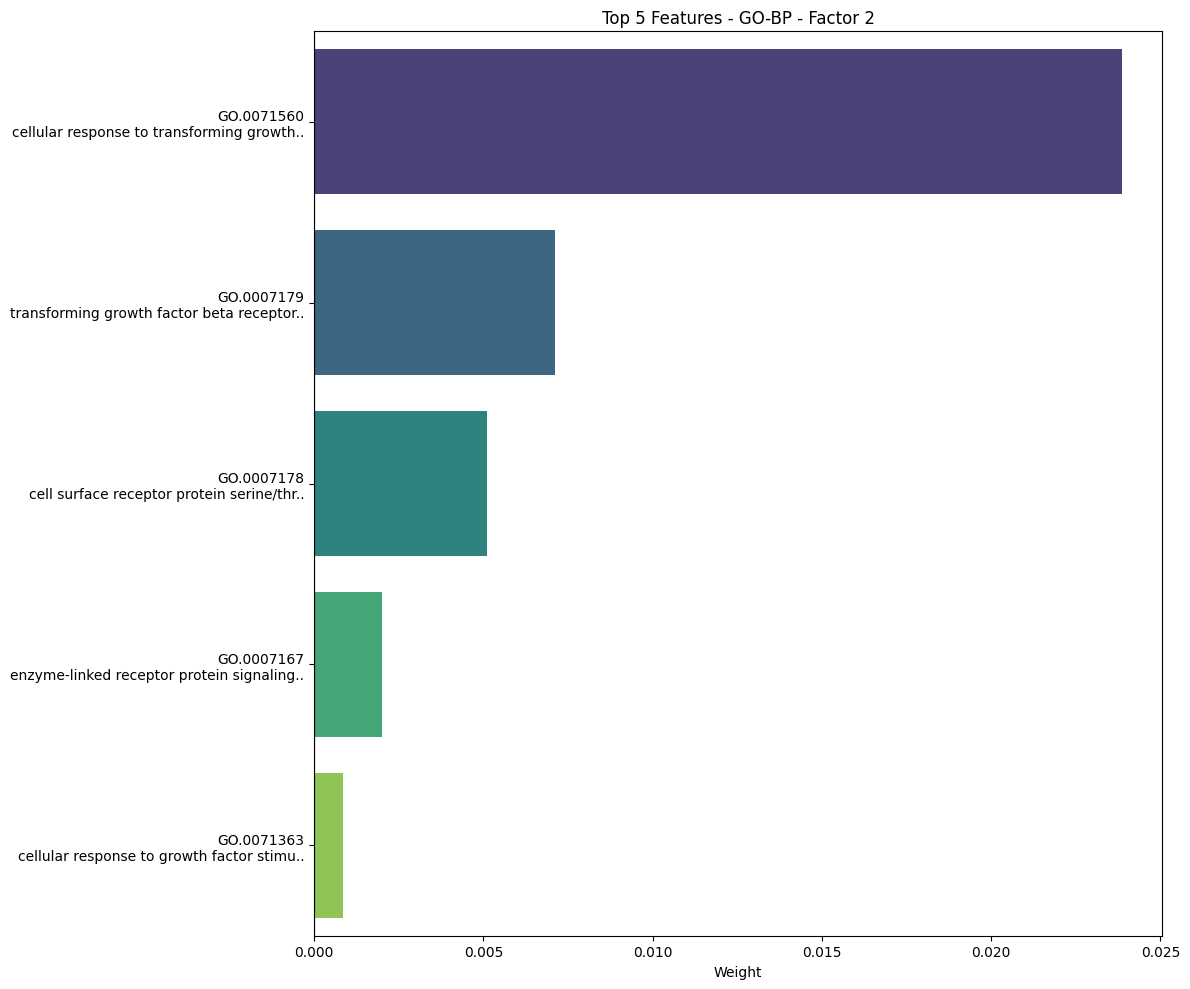

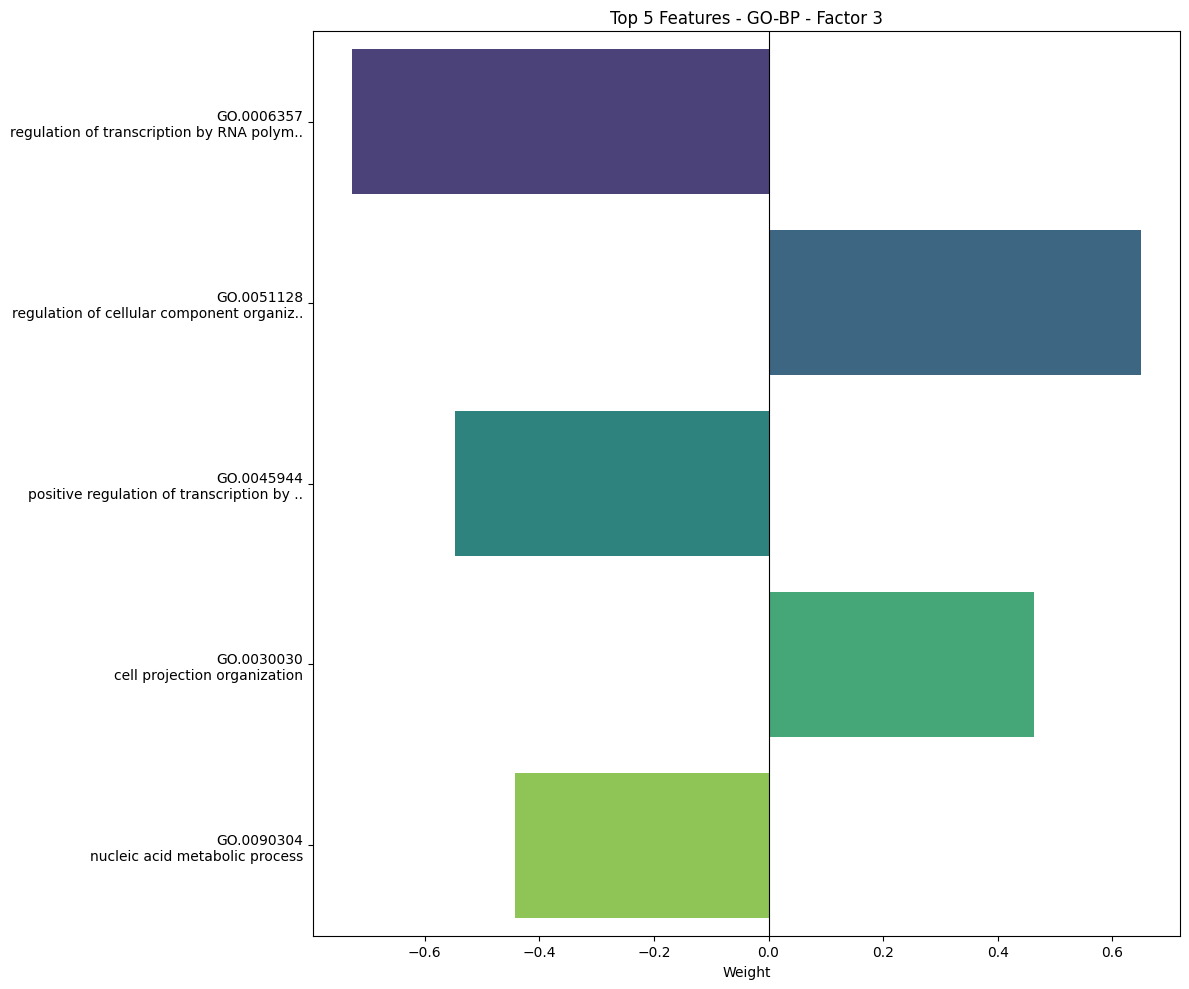

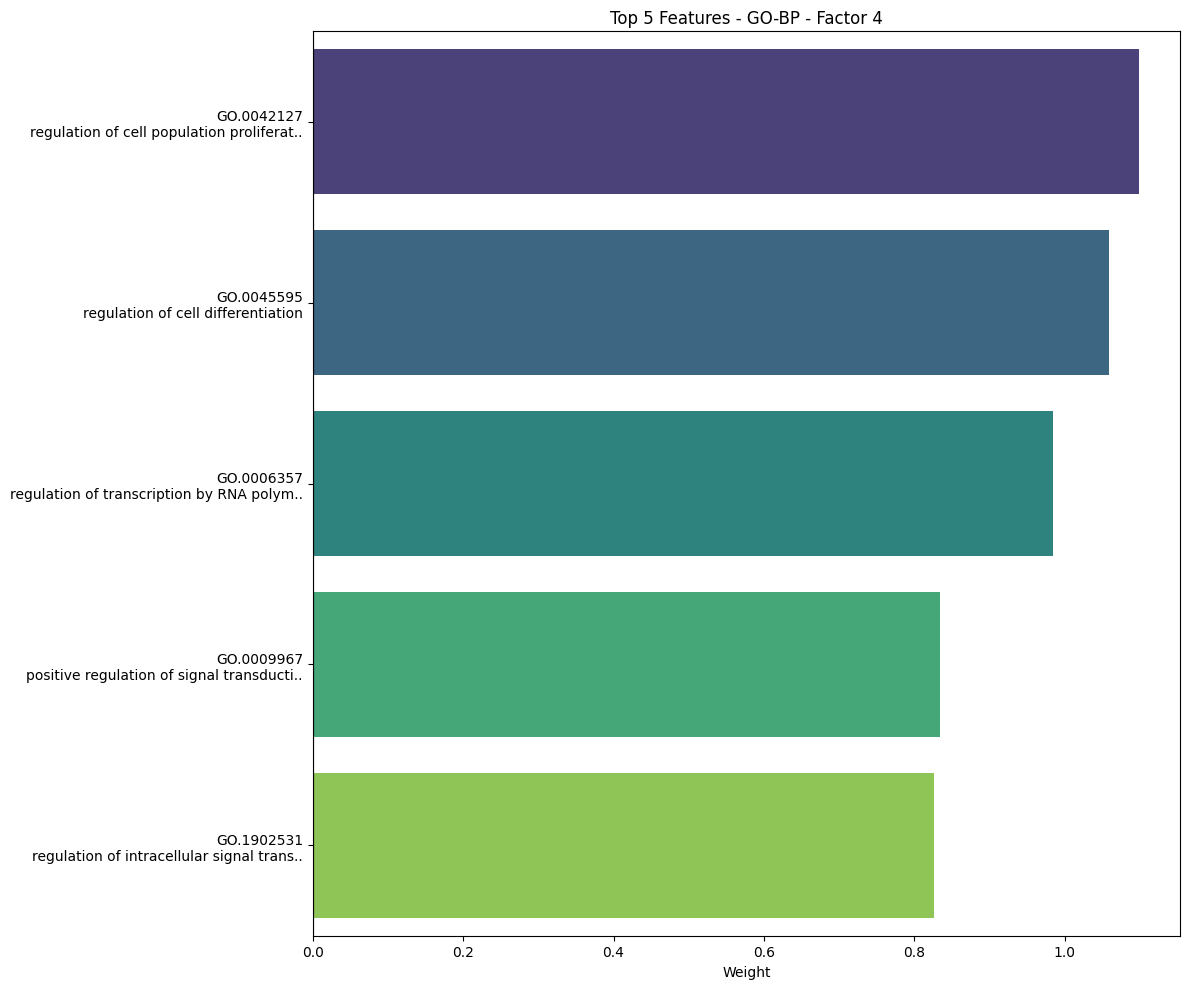

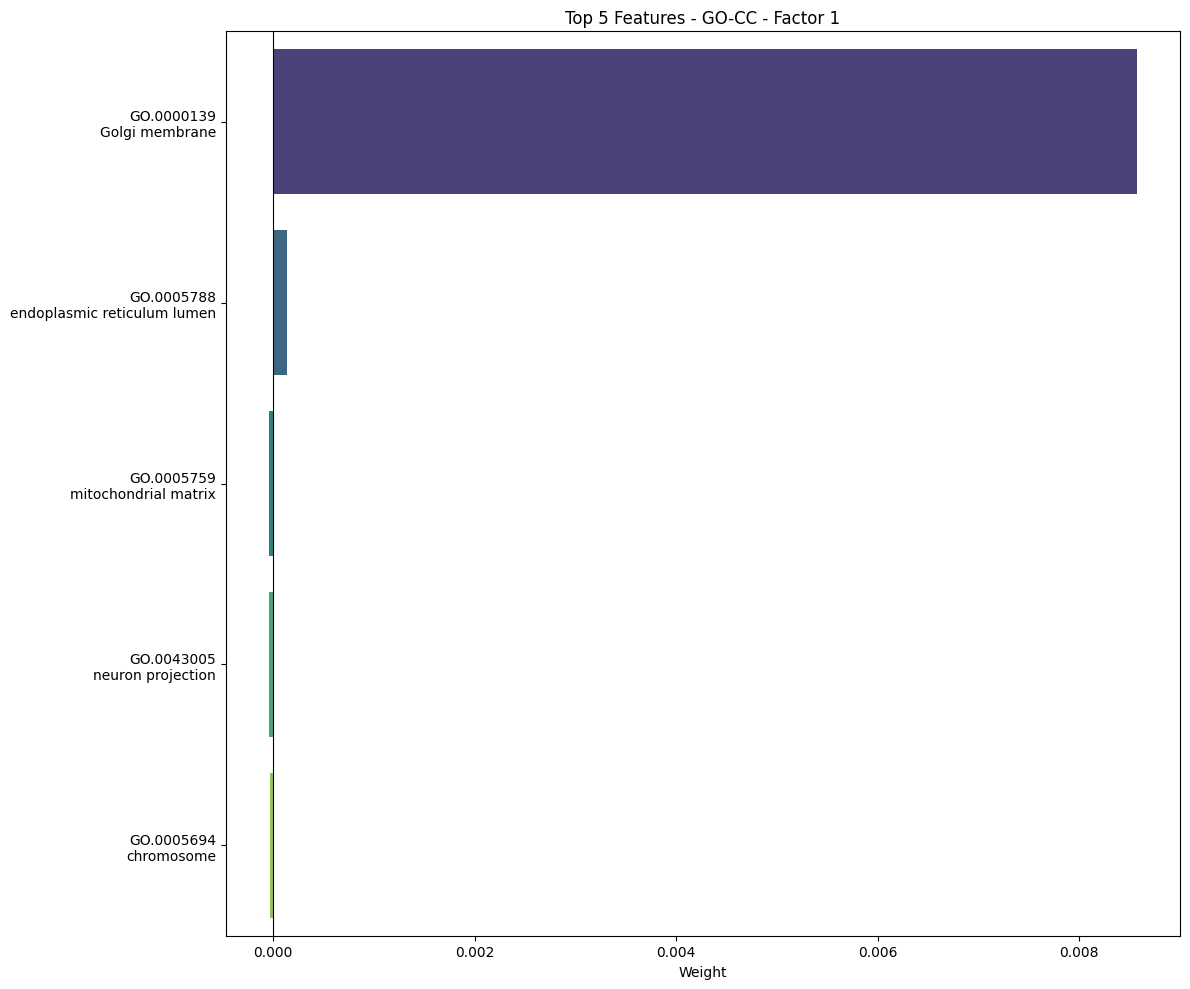

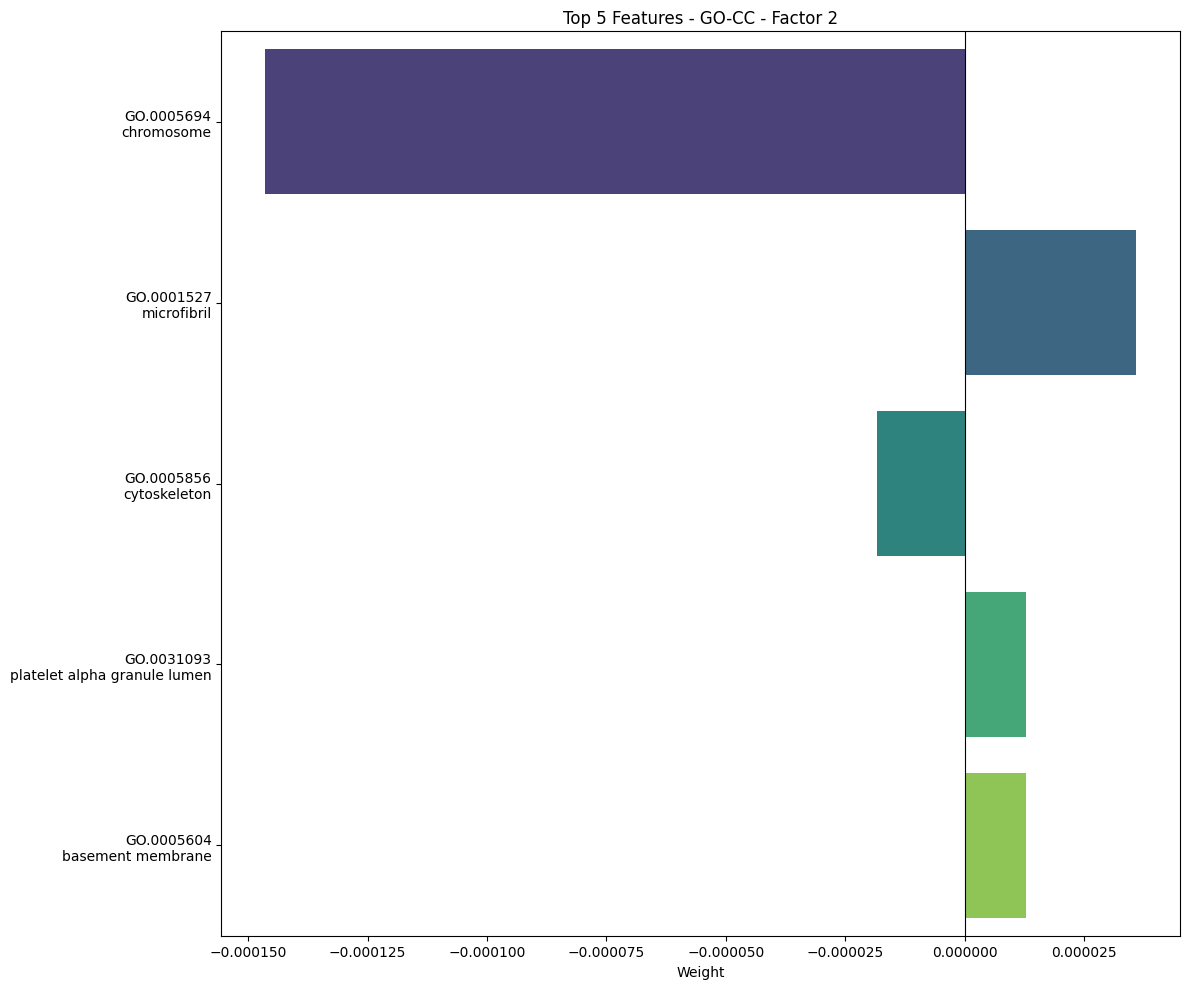

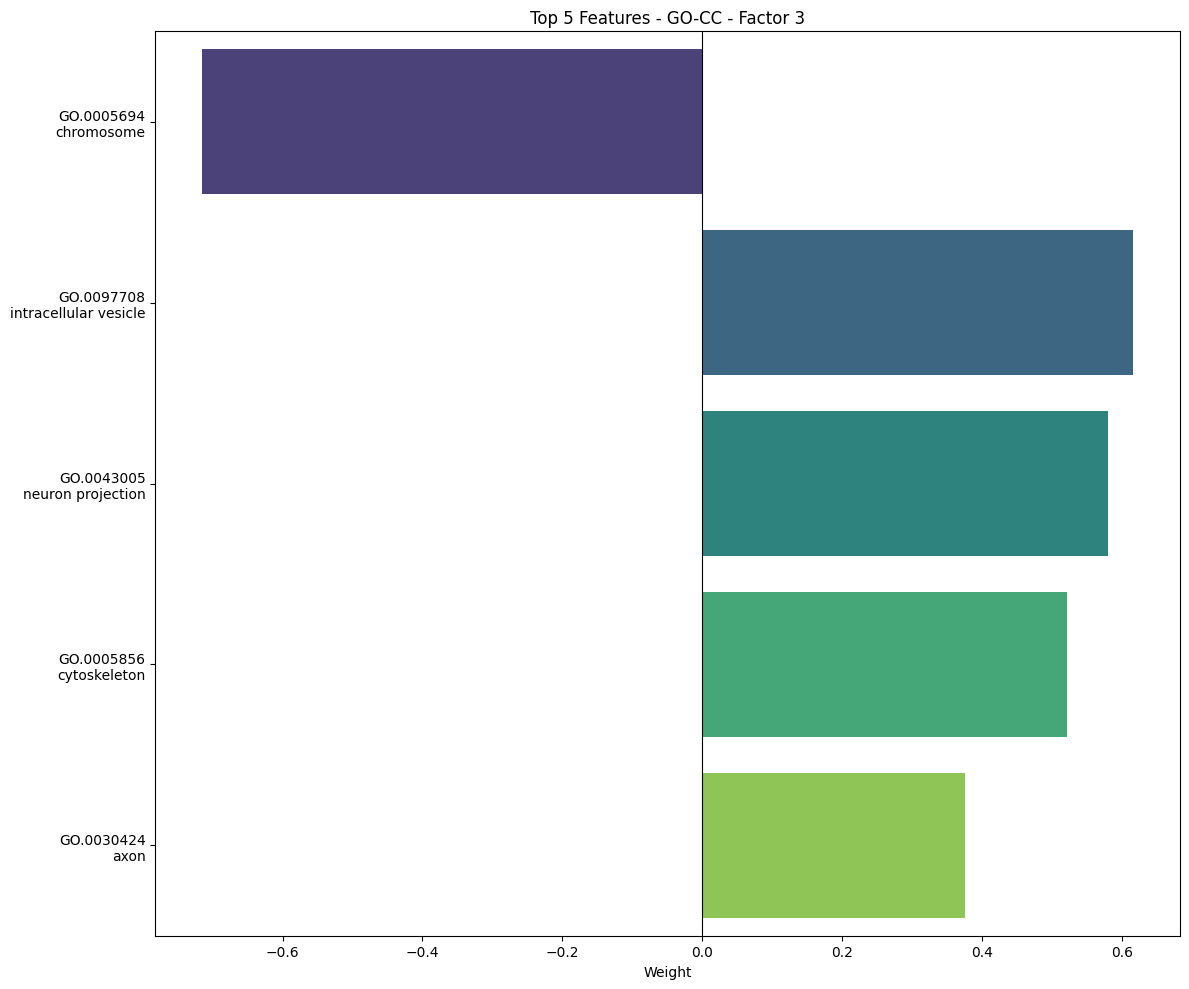

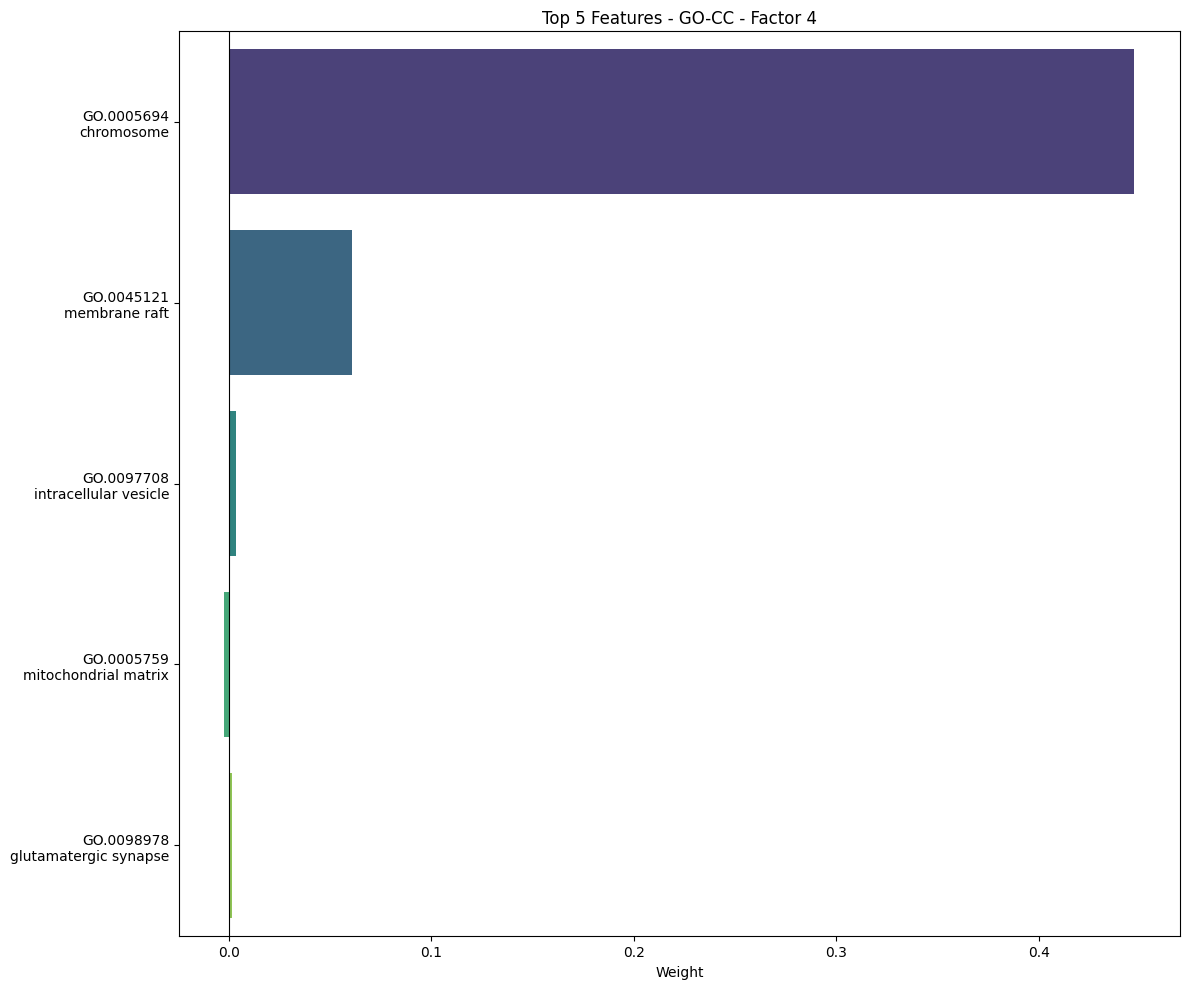

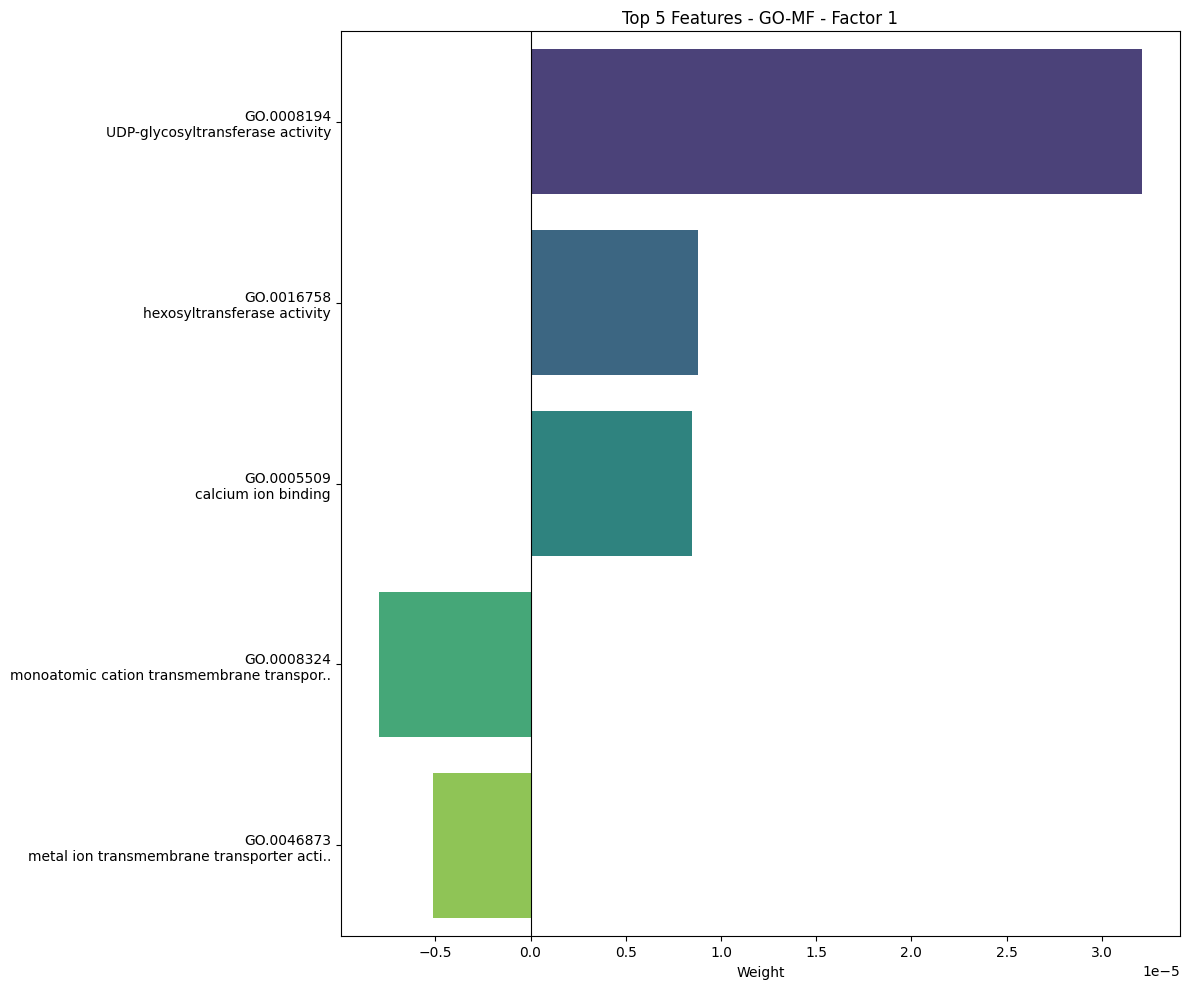

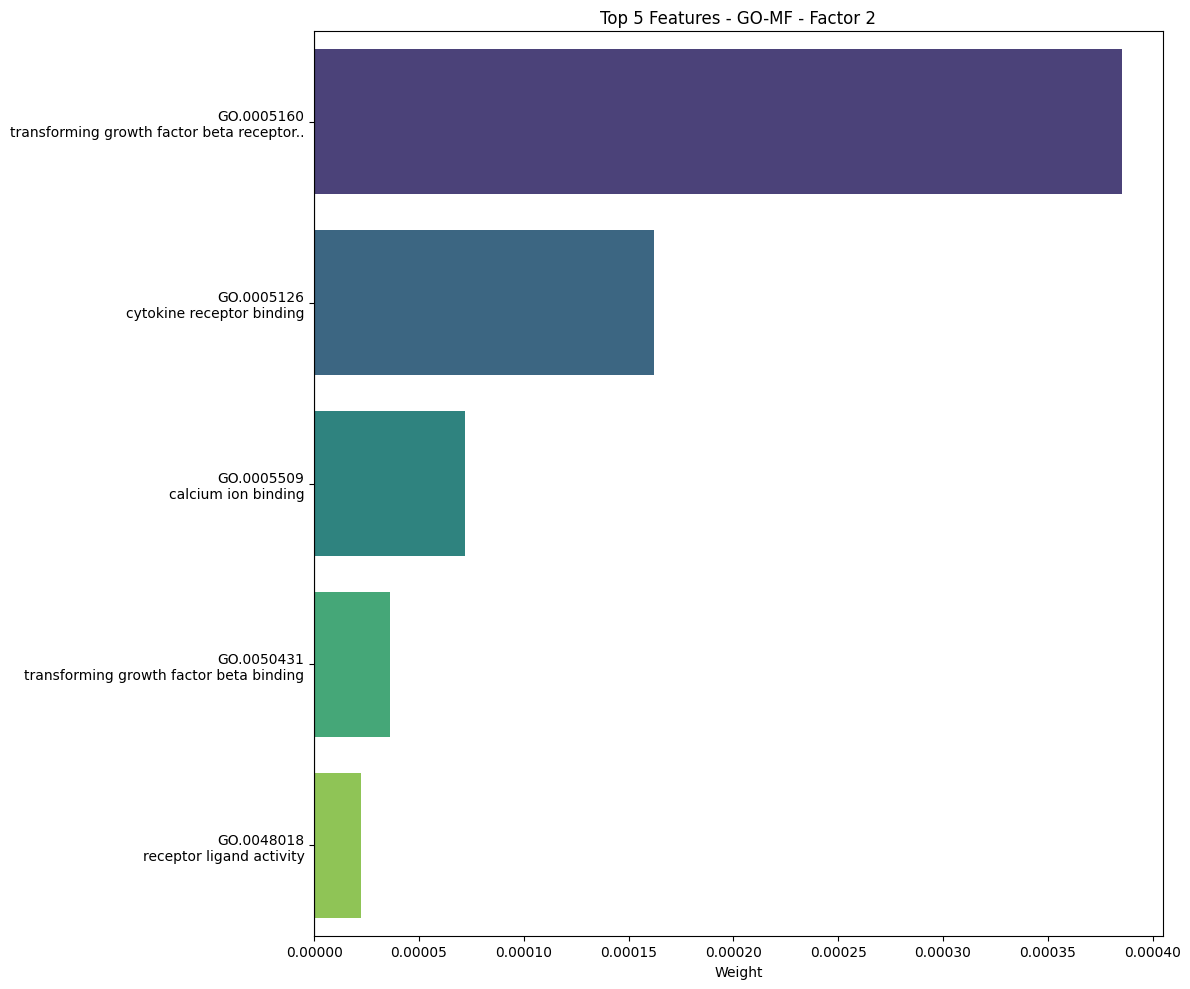

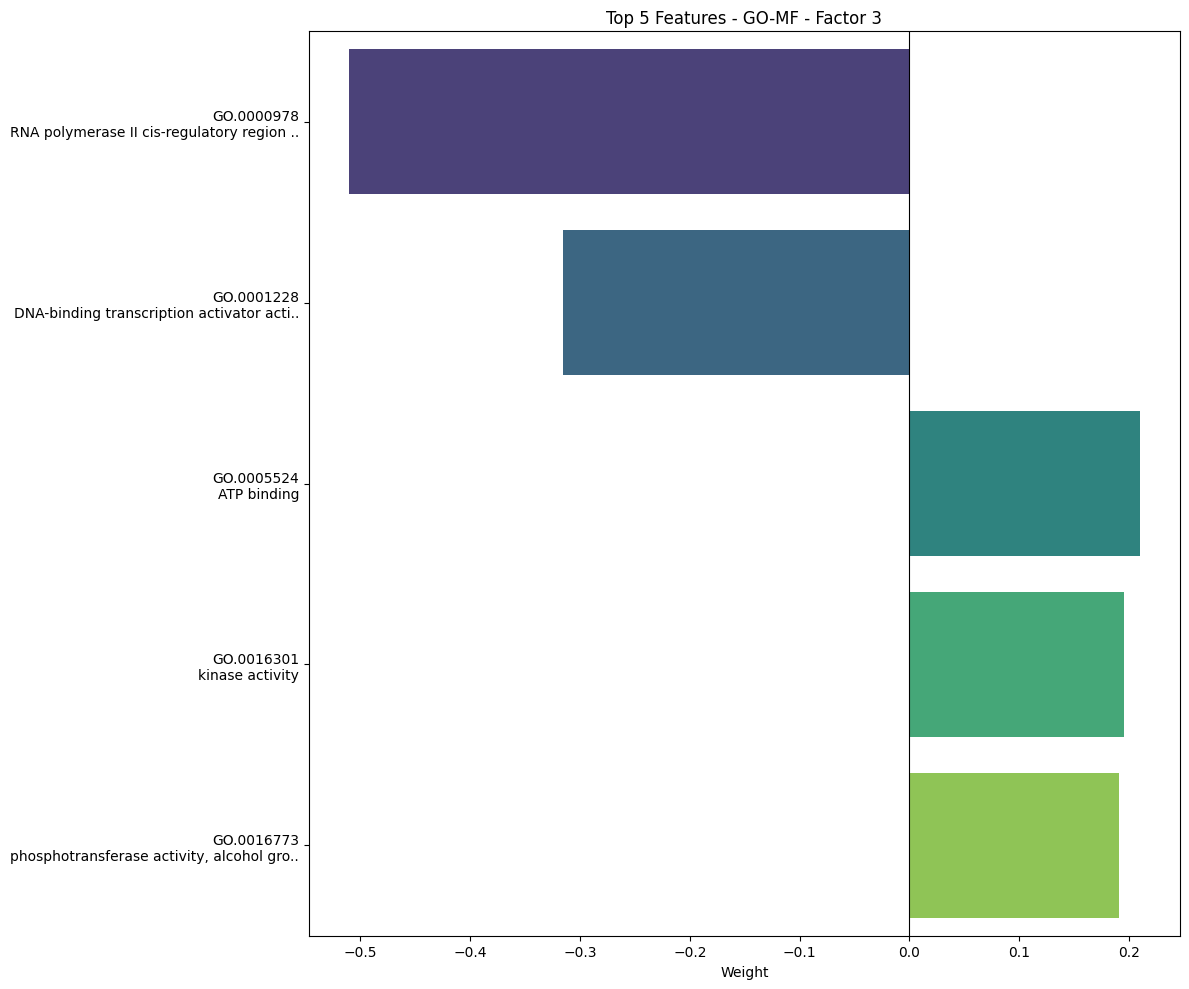

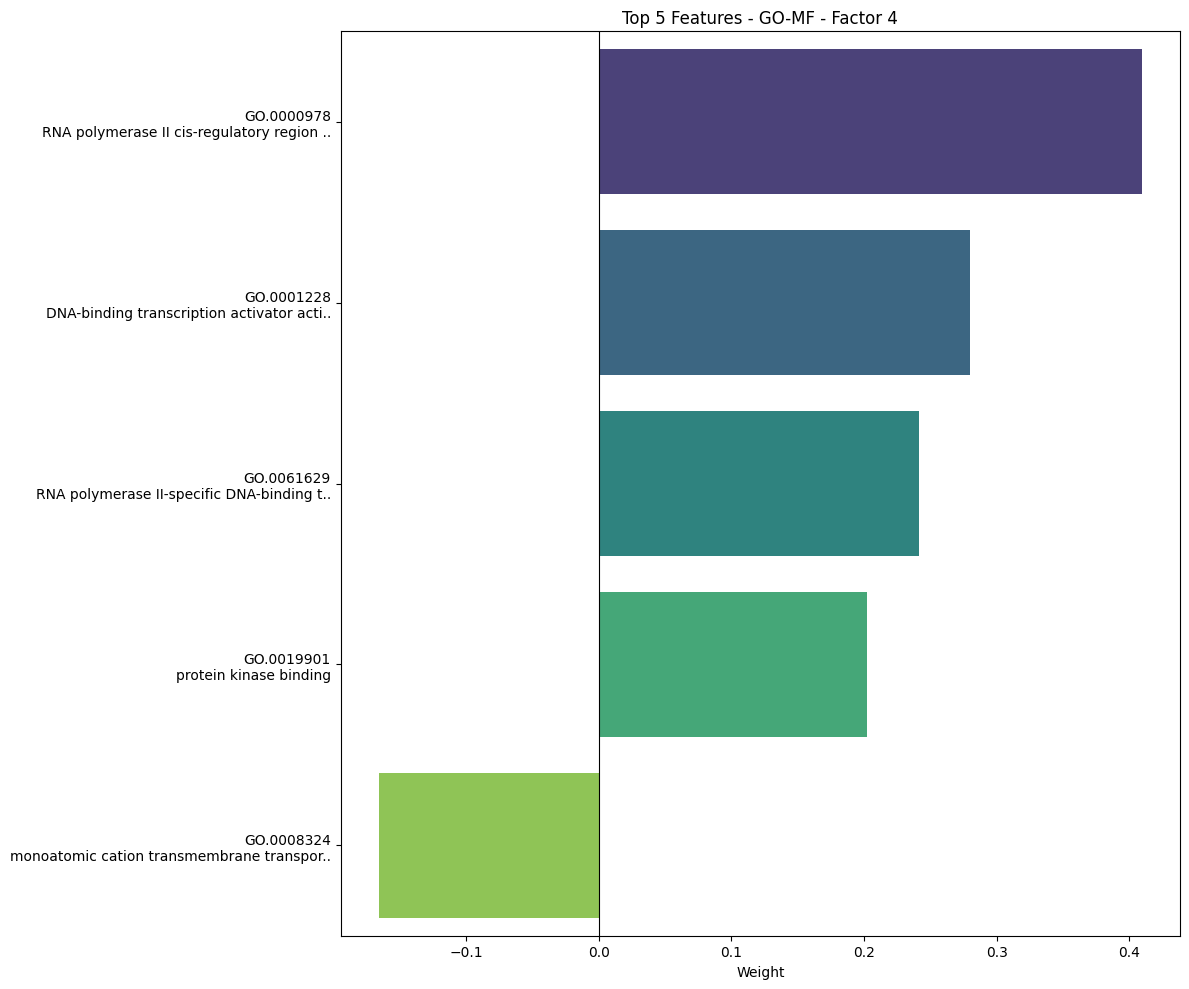

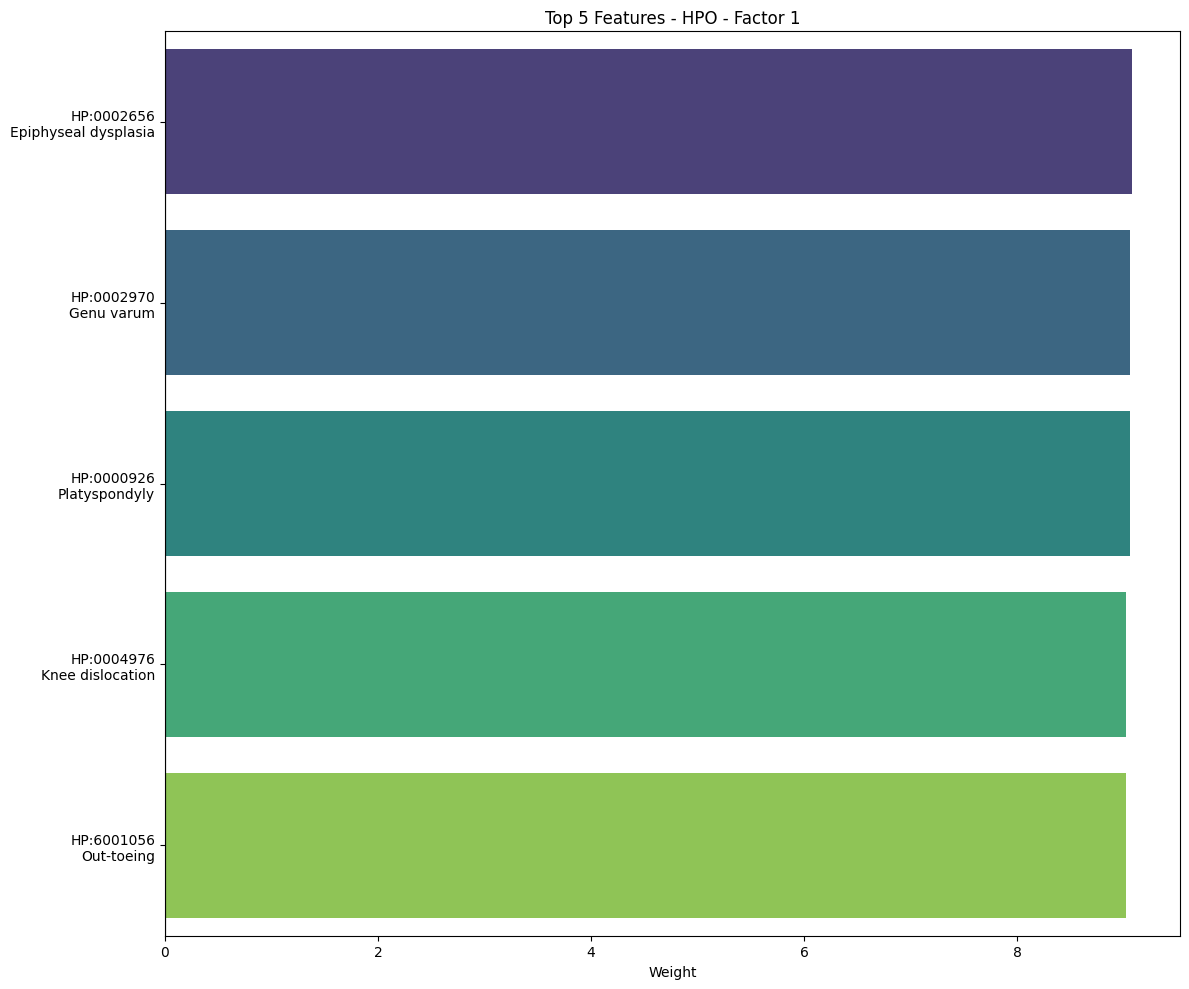

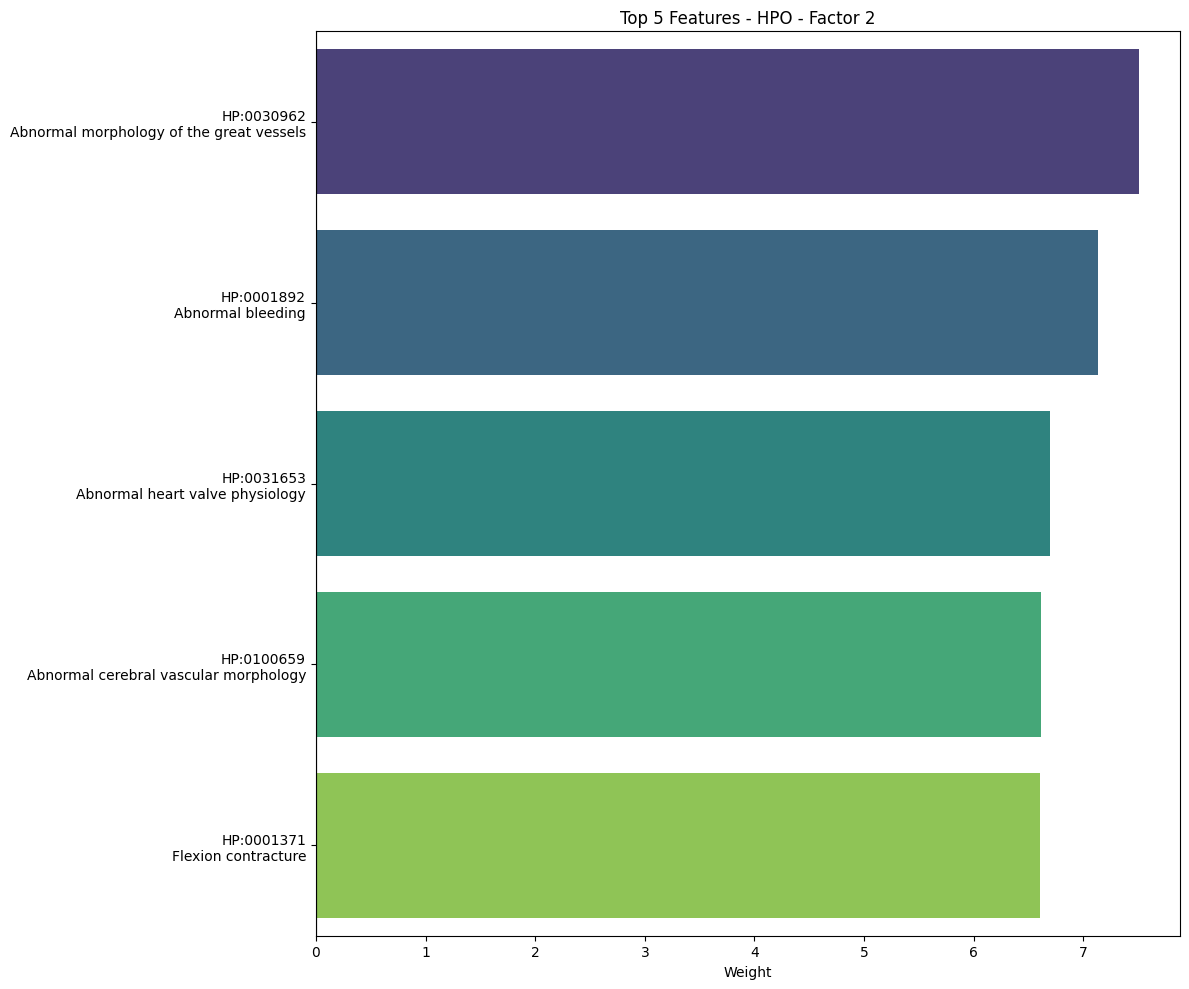

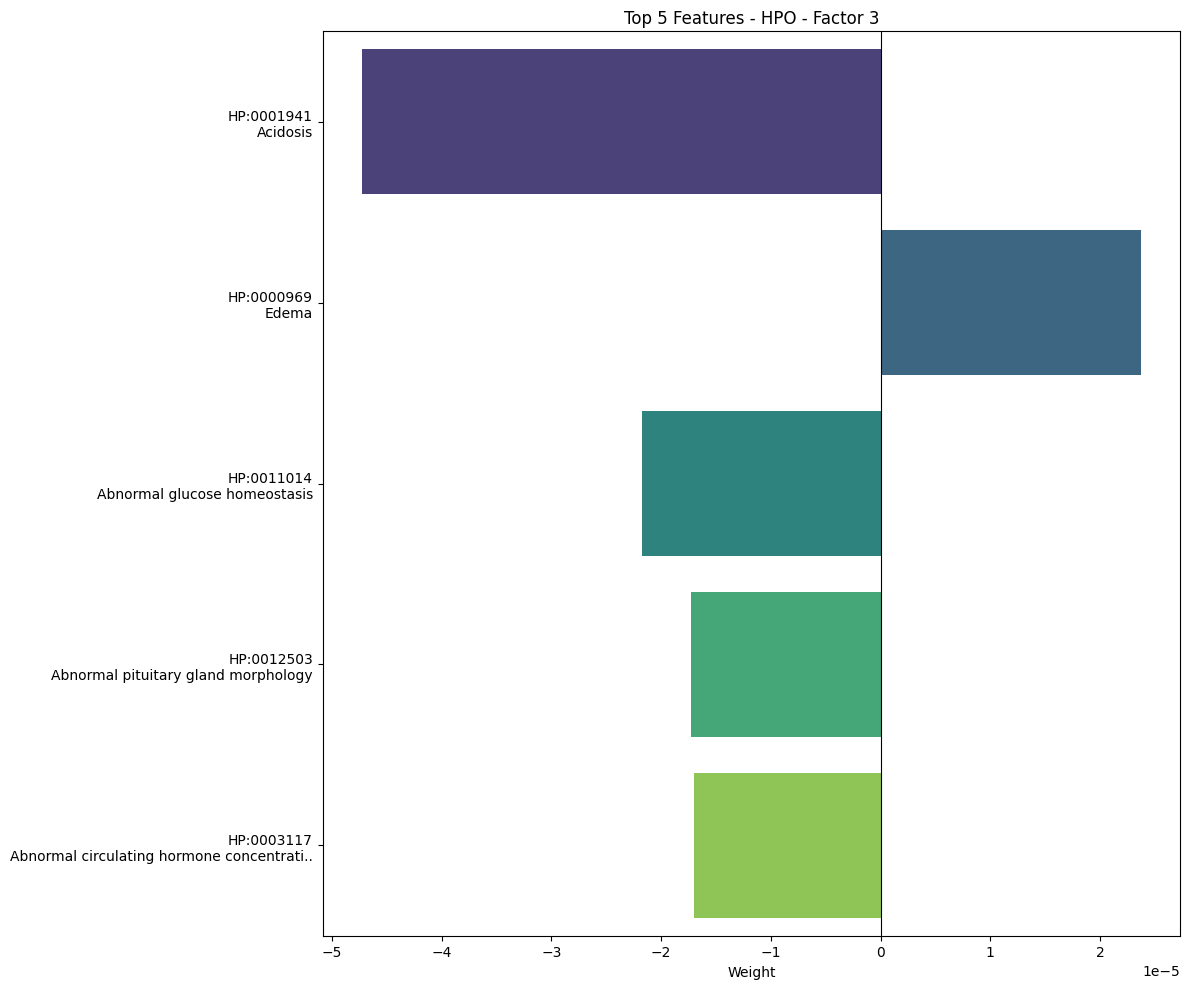

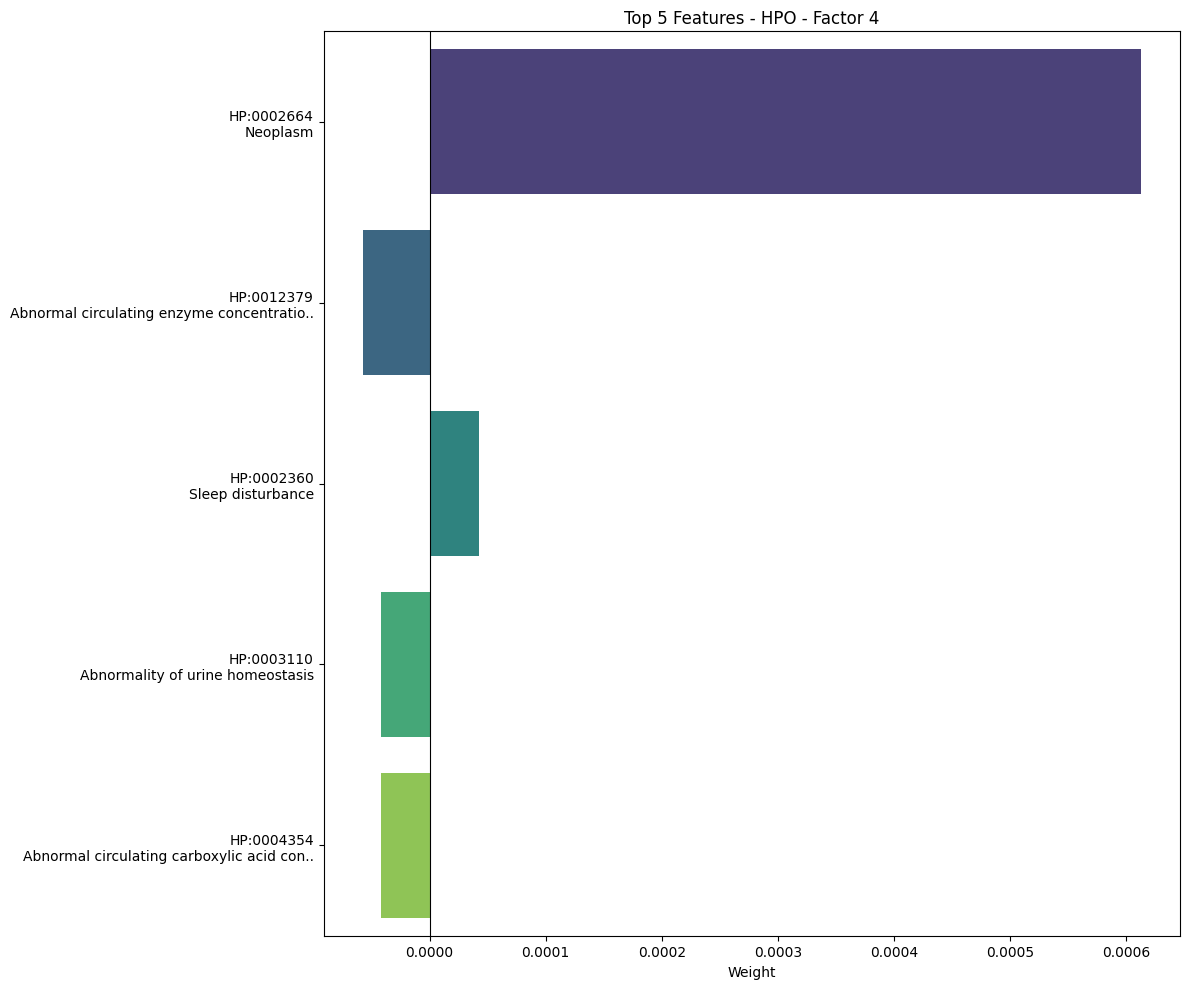

In [15]:
for vista in model.views:
    for i in range(4):
        plot_weights_fixed_translated(vista, factor_index=i)

In [9]:
def plot_all_views_aggregated(factor_index=0, n_top=15):
    """
    Cicla su tutte le view in file_paths, unisce i pesi, 
    ordina per valore assoluto globale e plotta i top N.
    """
    
    all_weights_list = []
    
    for view_name in model.views:
        
        # Load Weights
        try:

            w_df = model.get_weights(views=view_name, factors=factor_index, df=True)
        except Exception as e:
            print(f"Skipping {view_name}: Error loading weights ({e})")
            continue

        try:
            if view_name in file_paths:
                csv_cols = pd.read_csv(file_paths[view_name], index_col=0, nrows=0).columns.tolist()
                
                if len(csv_cols) == len(w_df):
                    w_df.index = csv_cols
                else:
                    print(f"Warning: Column count mismatch for {view_name}. Keeping generic IDs.")
        except Exception as e:
            print(f"Error reading CSV for {view_name}: {e}")

        # --- Normalizza il nome della colonna dei pesi ---
        # Cerca la colonna numerica (il peso)
        val_col = None
        for c in w_df.columns:
            if pd.api.types.is_numeric_dtype(w_df[c]):
                val_col = c
                break
        
        if val_col is None:
            continue

        # Rinomina la colonna valore in 'weight' per poter concatenare tutto dopo
        w_df = w_df.rename(columns={val_col: 'weight'})
        
        # Aggiunge colonna per tracciare la provenienza (es. 'mRNA', 'Methylation')
        w_df['view'] = view_name
        
        # Salviamo l'ID originale (il nome del gene/feature)
        w_df['feature_id'] = w_df.index
        
        all_weights_list.append(w_df[['weight', 'view', 'feature_id']])

    if not all_weights_list:
        print("Nessun peso caricato.")
        return

    combined_df = pd.concat(all_weights_list, axis=0)

    # --- Ordinamento Globale ---
    combined_df['abs_val'] = combined_df['weight'].abs()
    top_features = combined_df.sort_values('abs_val', ascending=False).head(n_top)

    # --- Creazione Etichette (Translation) ---
    new_labels = []
    for _, row in top_features.iterrows():
        term_id = row['feature_id']
        view_source = row['view']
        
        # Chiama la tua funzione di traduzione esterna
        try:
            desc = get_term_description(term_id)
        except:
            desc = term_id
            
        short_desc = (desc[:40] + '..') if len(desc) > 40 else desc
        
        new_labels.append(f"{term_id}\n{short_desc}")

    top_features['plot_label'] = new_labels

    plt.figure(figsize=(12, 10 + (n_top // 5)))
    
    sns.barplot(
        data=top_features,
        x='weight',
        y='plot_label',
        hue='view',
        dodge=False,
        palette="viridis"
    )
    
    plt.title(f"Top {n_top} Global Features - Factor {factor_index+1}")
    plt.xlabel("Weight")
    plt.ylabel("")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.legend(title='View Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

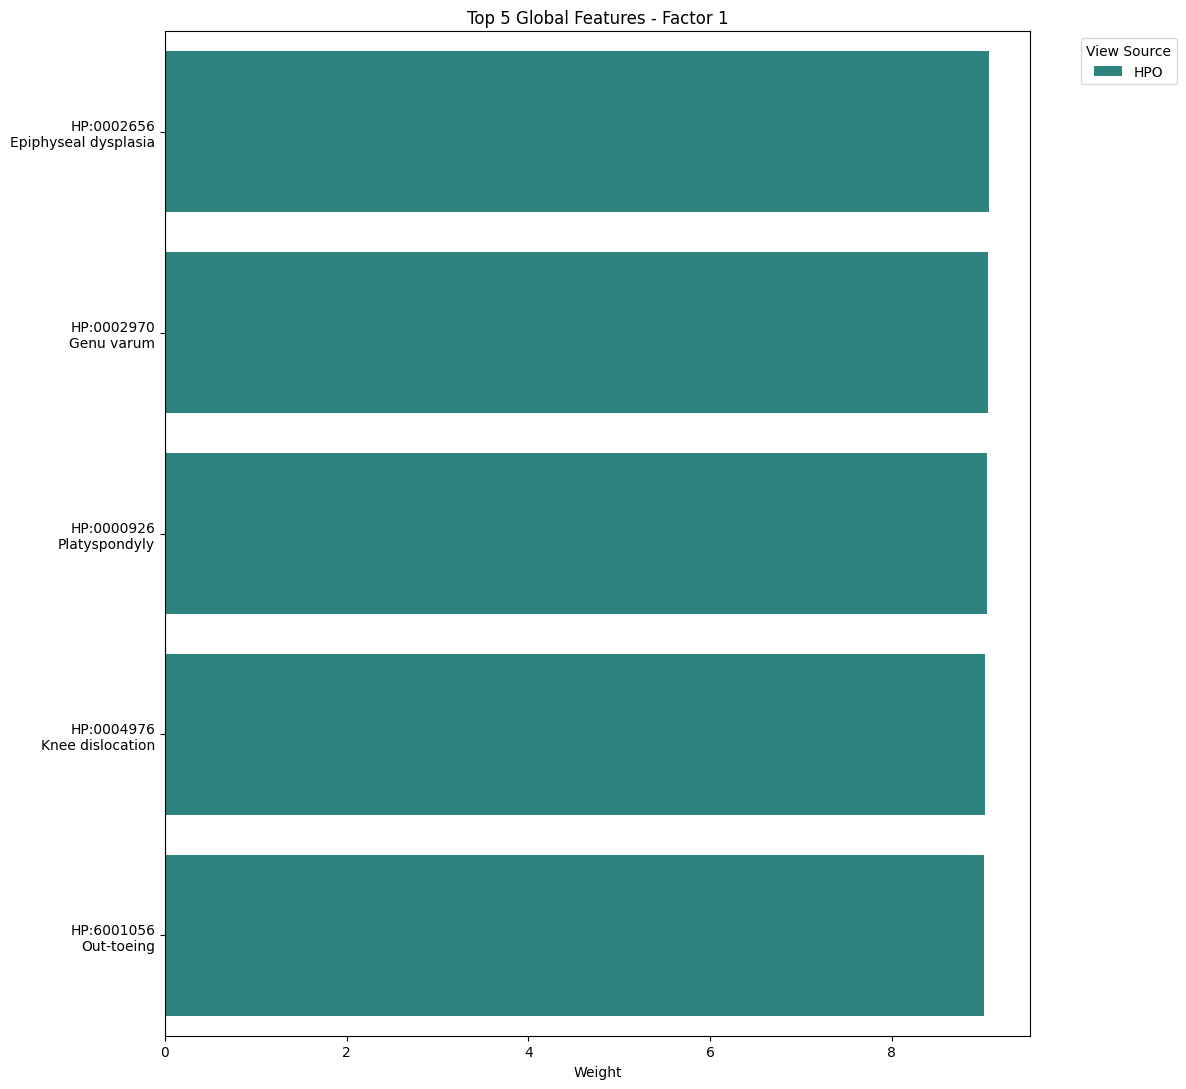

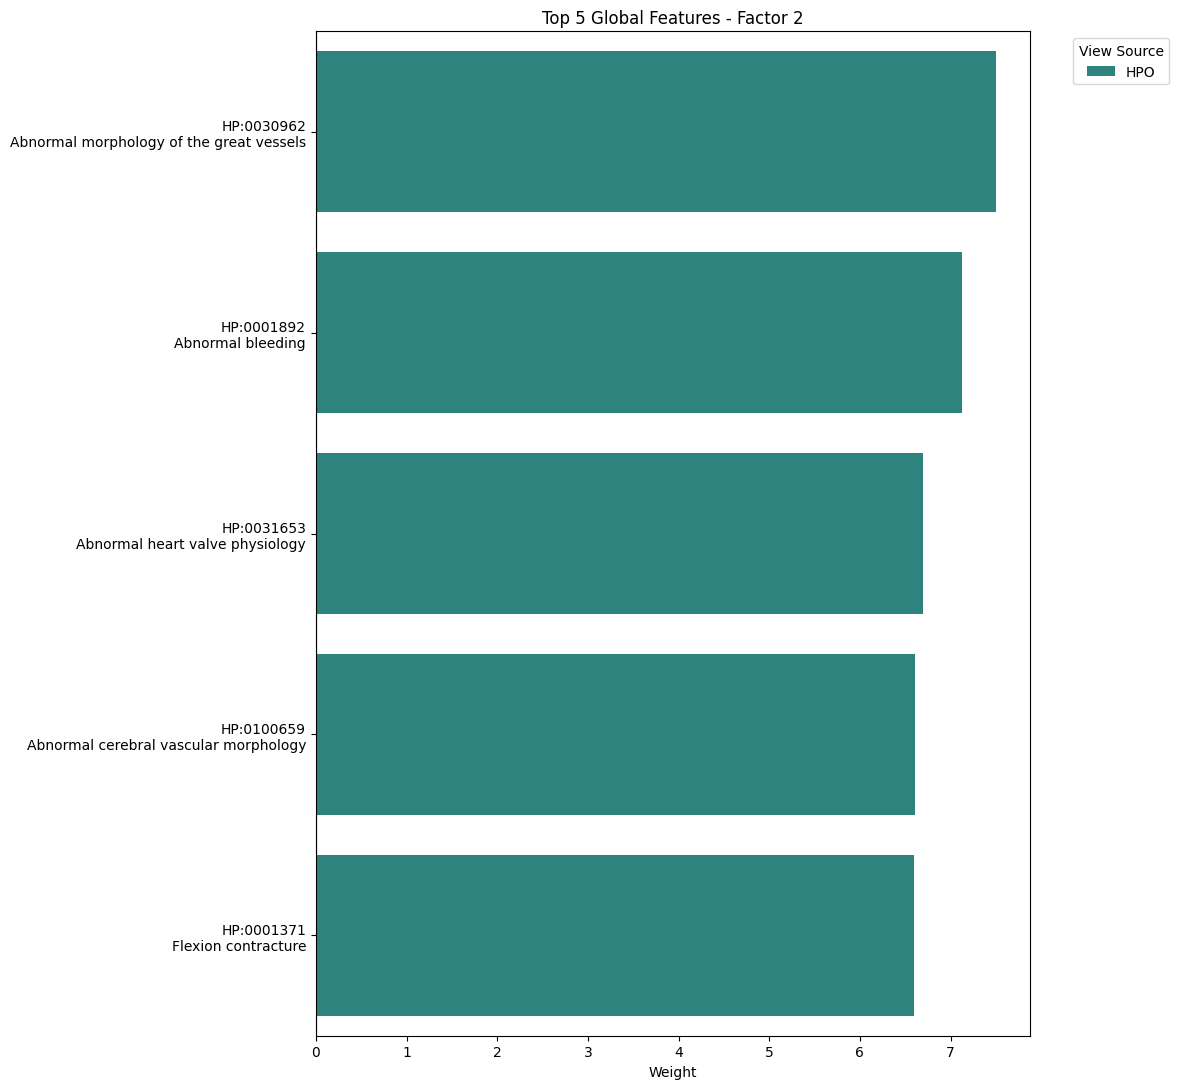

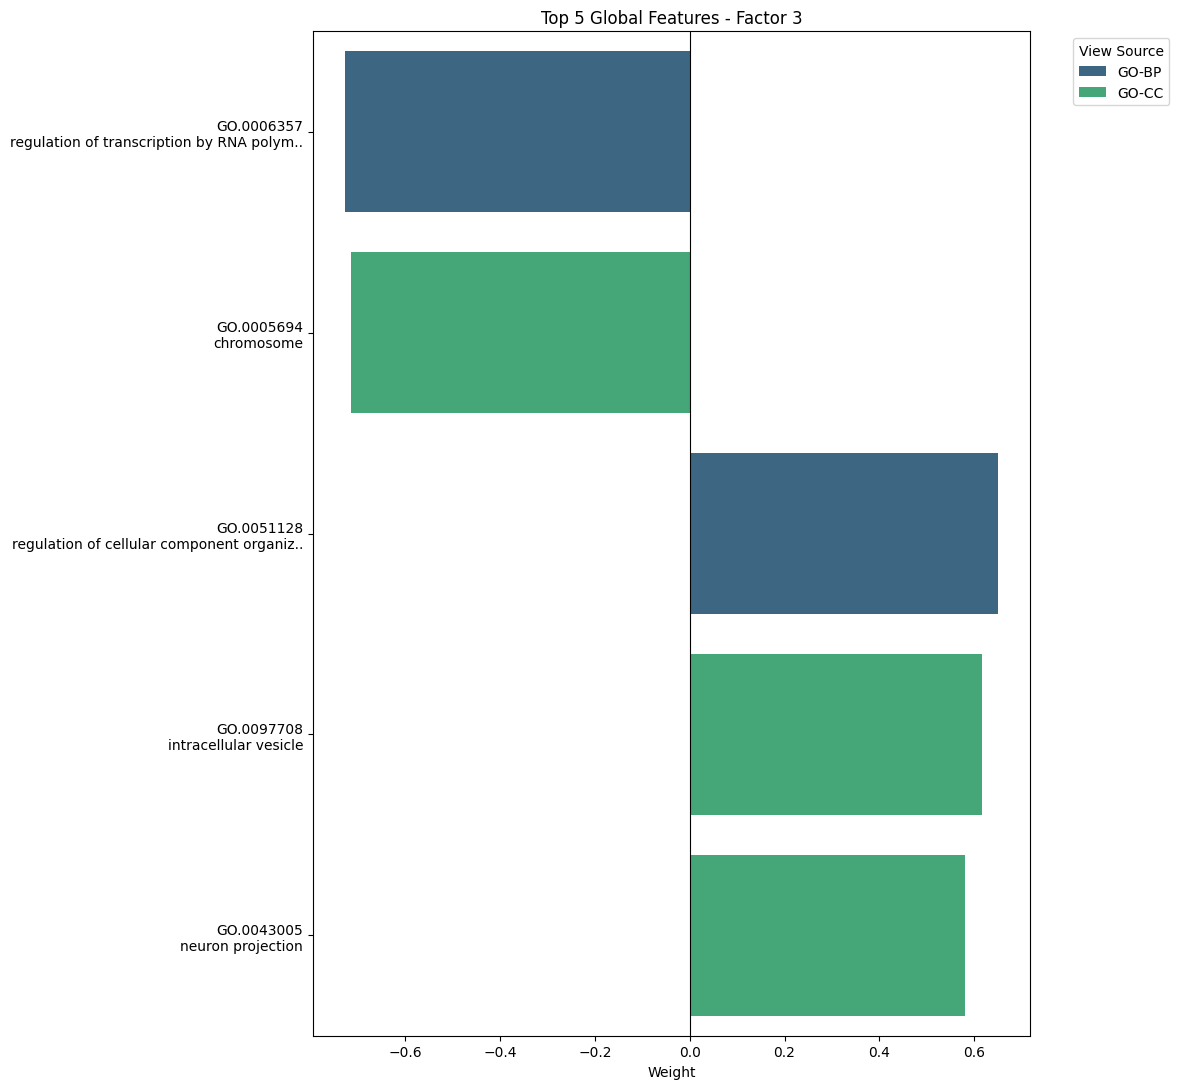

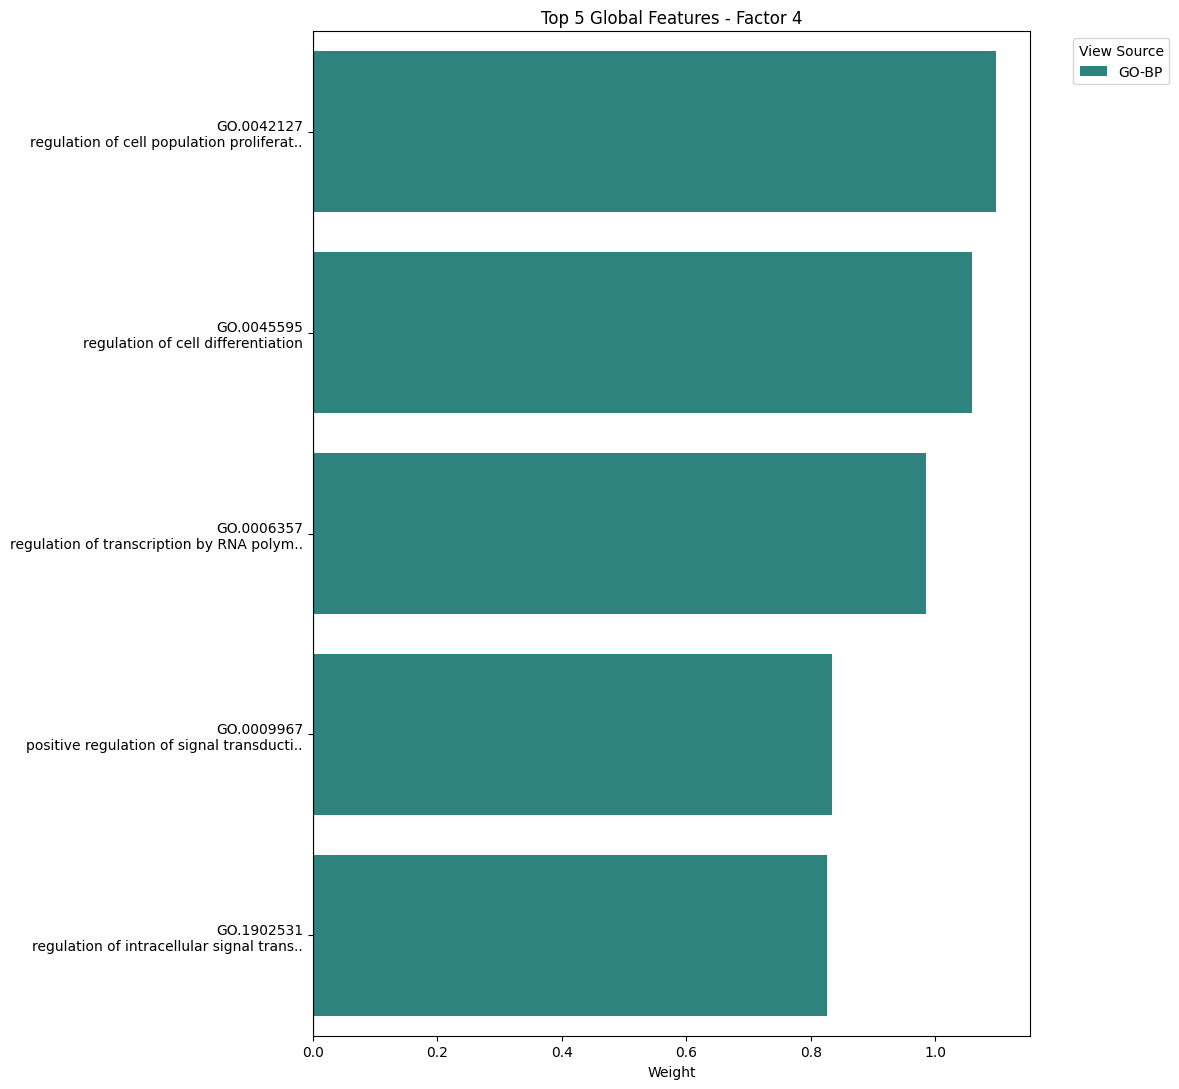

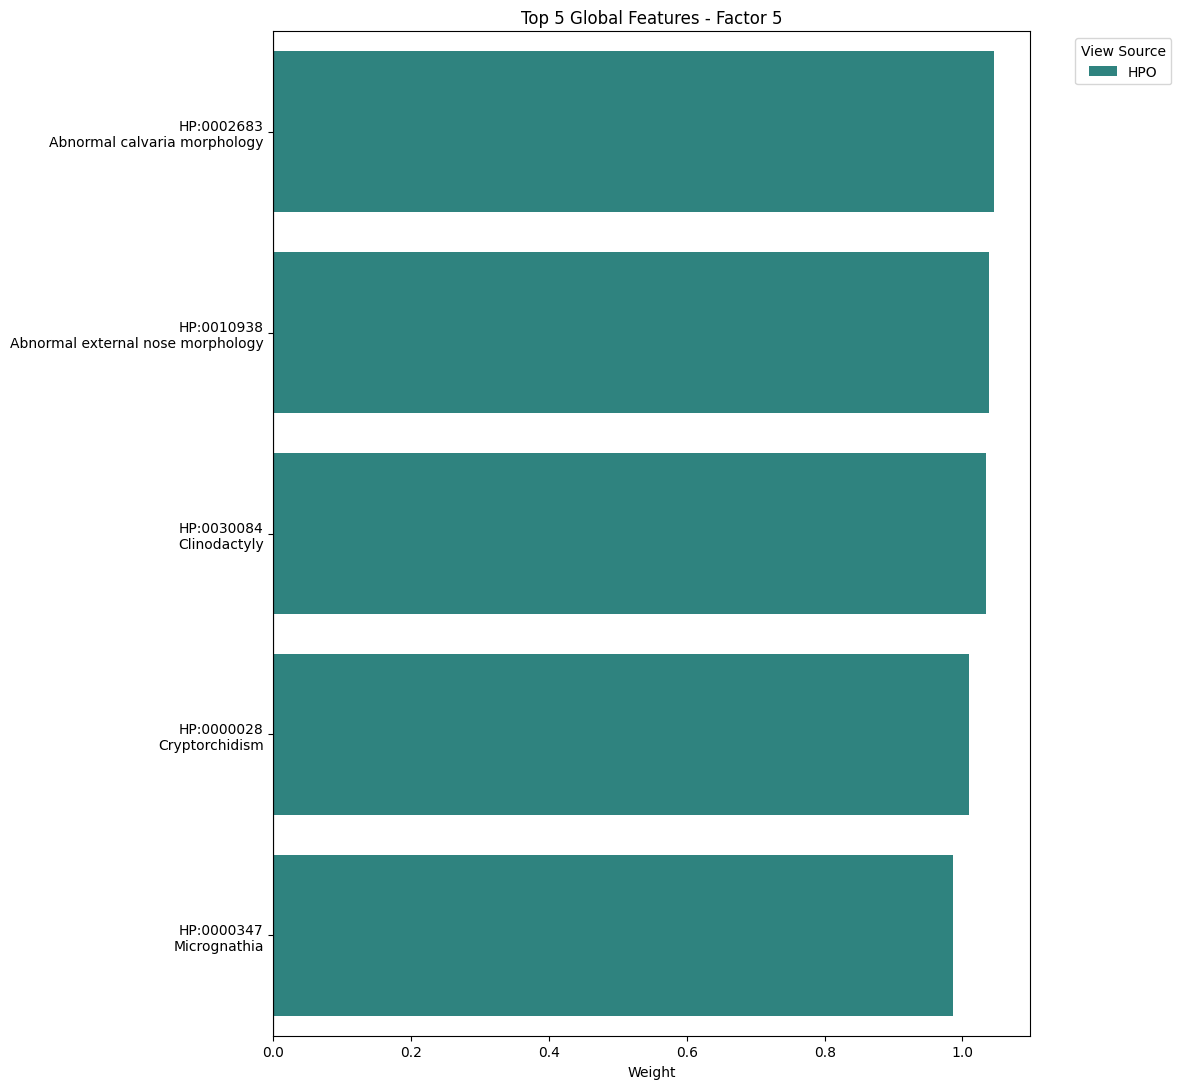

In [13]:
for factor_idx in range(5):
    plot_all_views_aggregated(factor_index=factor_idx, n_top=5)

In [ ]:
def analyze_view(sim_matrix_path, view_name):
    print(f"\n--- Analisi Vista: {view_name} ---")
    
    sim_df = pd.read_csv(sim_matrix_path, index_col=0)
    
    distance_matrix = 1 - sim_df.values
    distance_matrix[distance_matrix < 0] = 0
    
    reducer = umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        metric='precomputed',
        random_state=42
    )
    
    embedding = reducer.fit_transform(distance_matrix)
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=30,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    
    cluster_labels = clusterer.fit_predict(embedding)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    print(f"   -> Trovati {n_clusters} cluster.")
    print(f"   -> Geni scartati come rumore: {n_noise}")

    plt.figure(figsize=(10, 8))
    
    # Definizione colori
    noise_color = (0.8, 0.8, 0.8)
    palette = sns.color_palette('tab20', n_colors=n_clusters)
    cluster_colors = [palette[x] if x >= 0 else noise_color for x in cluster_labels]
    
    plt.scatter(
        embedding[:, 0], 
        embedding[:, 1], 
        c=cluster_colors, 
        s=5, 
        alpha=0.6
    )
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Noise', 
               markerfacecolor=noise_color, markersize=10),
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(f'UMAP Projection - {view_name} ({n_clusters} clusters)', fontsize=16)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    
    plt.savefig(f"plot_umap_{view_name}.png", dpi=300)
    plt.close()
    
    results = pd.DataFrame({
        'Gene': sim_df.index,
        'Cluster': cluster_labels,
        'UMAP_1': embedding[:, 0],
        'UMAP_2': embedding[:, 1]
    })
    results.to_csv(f"clusters_{view_name}.csv", index=False)
    
    return n_clusters, n_noise

In [ ]:
files = {
    "BP": "snf_similarity_BP.csv",
    "CC": "snf_similarity_CC.csv",
    "MF": "snf_similarity_MF.csv",
    "HPO": "snf_similarity_HPO.csv"
}

summary = []
for name, path in files.items():
    n_clust, n_noise = analyze_view(path, name)
    summary.append({'View': name, 'Clusters': n_clust, 'Noise_Genes': n_noise})

print(pd.DataFrame(summary))

In [ ]:
import pandas as pd
import snf
import os
import numpy as np

def run_snf_with_affinity_calculation(view_names, output_dir='.'):
    """
    1. Carica le matrici di dati originali (Feature Matrix).
    2. Calcola la matrice di affinità per ciascuna vista usando snf.make_affinity.
    3. Fonde le affinità con snf
    """
    affinity_matrices = []
    gene_list = None

    K = 20 
    mu = 0.5 
    
    for name in view_names:

        filename = f"mofa_input_{name}.csv" 
        file_path = os.path.join(output_dir, filename)
        
        if not os.path.exists(file_path):
            print(f"ERRORE: File dati {filename} non trovato.")
            return
        
        df = pd.read_csv(file_path, index_col=0)
        
        # Gestione lista geni (consistency check)
        if gene_list is None:
            gene_list = df.index.tolist()
        elif df.index.tolist() != gene_list:
            print(f"ATTENZIONE: Indici non allineati per {name}. Ignoro questa vista.")
            continue
        
        data_matrix = df.values
        
        affinity = snf.make_affinity(data_matrix, metric='euclidean', K=K, mu=mu)
        
        affinity_matrices.append(affinity)

    t = 20
    print(f"   Fusione di {len(affinity_matrices)} matrici con SNF (K={K}, t={t})...")
    
    W_fused = snf.snf(affinity_matrices, K=K, t=t)
    
    print("   SNF completato.")
    
    df_fused = pd.DataFrame(W_fused, index=gene_list, columns=gene_list)
    output_file = os.path.join(output_dir, "snf_fused_matrix_calculated.csv")
    df_fused.to_csv(output_file)
    
    print(f"   Matrice Fusa salvata in: {output_file}")
    
    return df_fused

In [7]:
view_names = ["BP", "CC", "MF", "HPO"]
df_fused_snf = run_snf_with_affinity_calculation(view_names)

if df_fused_snf is not None:
    print(f"\nRange Matrice Fusa: [{df_fused_snf.values.min():.4f}, {df_fused_snf.values.max():.4f}]")

--- Fase 3: Calcolo Affinità e Fusione (SNF) ---
   Calcolo affinità per BP (3317, 4807)...
   -> Matrice affinità ottenuta: (3317, 3317)
   Calcolo affinità per CC (3317, 461)...
   -> Matrice affinità ottenuta: (3317, 3317)
   Calcolo affinità per MF (3317, 911)...
   -> Matrice affinità ottenuta: (3317, 3317)
   Calcolo affinità per HPO (3317, 6038)...
   -> Matrice affinità ottenuta: (3317, 3317)
   Fusione di 4 matrici con SNF (K=20, t=20)...
   SNF completato.
   Matrice Fusa salvata in: .\snf_fused_matrix_calculated.csv

Range Matrice Fusa: [0.0002, 0.5697]


--- Visualizzazione SNF: snf_fused_matrix_calculated.csv ---
   Dati pronti: (3317, 3317) geni.
   Esecuzione UMAP...
   Esecuzione HDBSCAN (min_cluster_size=20)...
   -> Trovati 48 cluster. (Geni 'Noise': 1147)


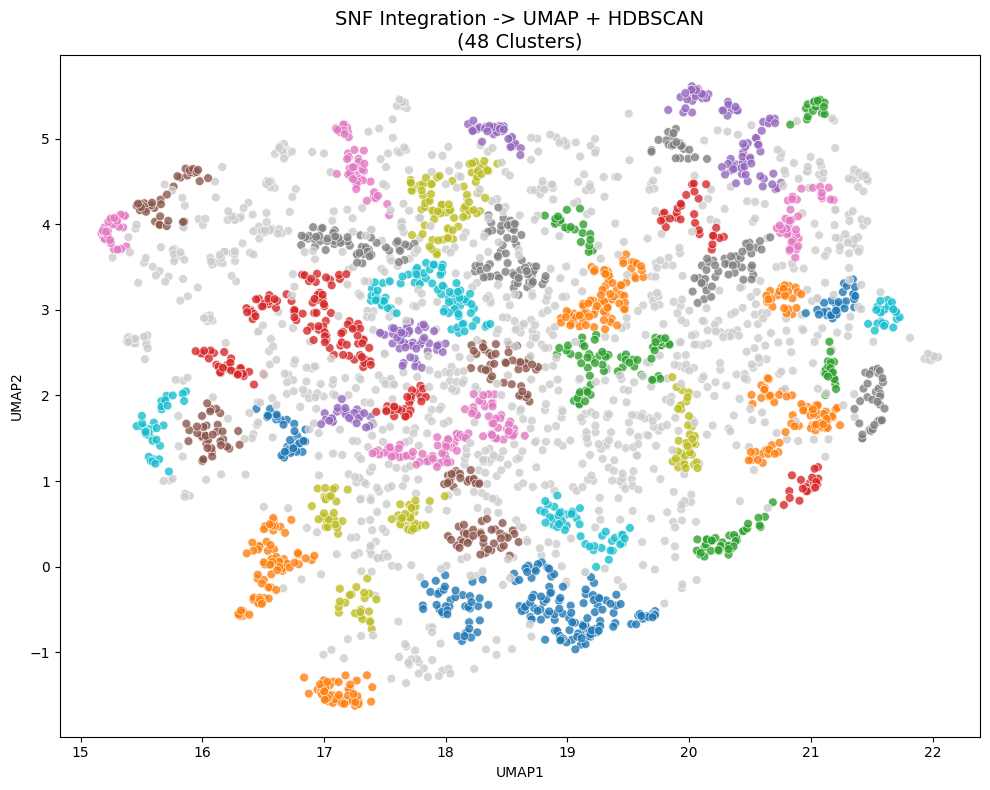

In [ ]:
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import os

def visualize_snf_clustering(fused_matrix_path, min_cluster_size=15):
    
    df_fused = pd.read_csv(fused_matrix_path, index_col=0)
    W = df_fused.values
    distance_matrix = 1 - W
    
    distance_matrix[distance_matrix < 0] = 0
    np.fill_diagonal(distance_matrix, 0)
    
    reducer = umap.UMAP(
        metric='precomputed',
        n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=42
    )
    embedding = reducer.fit_transform(distance_matrix)
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric='euclidean'
    )
    cluster_labels = clusterer.fit_predict(embedding)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    plt.figure(figsize=(10, 8))
    
    plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    plot_df['Cluster'] = cluster_labels
    plot_df['Cluster'] = plot_df['Cluster'].astype(str)
    
    unique_labels = sorted(plot_df['Cluster'].unique(), key=lambda x: int(x))
    palette = sns.color_palette("tab10", len(unique_labels))
    color_map = dict(zip(unique_labels, palette))
    
    if '-1' in color_map:
        color_map['-1'] = (0.8, 0.8, 0.8)
        
    sns.scatterplot(
        data=plot_df,
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=color_map,
        s=40,
        alpha=0.8,
        legend=False
    )
    
    plt.title(f"SNF Integration -> UMAP + HDBSCAN\n({n_clusters} Clusters)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # F. Salvataggio risultati
    df_results = pd.DataFrame({
        'Gene': df_fused.index,
        'Cluster': cluster_labels,
        'UMAP1': embedding[:, 0],
        'UMAP2': embedding[:, 1]
    })
    
    return df_results

risultati = visualize_snf_clustering("snf_fused_matrix_calculated.csv", min_cluster_size=20)

In [12]:
risultati

,Gene,Cluster,UMAP1,UMAP2
0,16,1,20.324976,0.213749
1,18,19,19.036985,-0.854403
2,19,39,16.780445,1.524935
3,20,39,16.699015,1.401814
4,21,39,16.694801,1.716174
...,...,...,...,...
3312,729230,34,18.515450,2.504360
3313,790955,-1,17.163828,-1.069901
3314,100127206,32,17.007570,2.620951
3315,100134444,5,15.243989,3.814791


In [13]:
risultati_puliti = risultati[risultati['Cluster'] != -1]

In [14]:
risultati_puliti

,Gene,Cluster,UMAP1,UMAP2
0,16,1,20.324976,0.213749
1,18,19,19.036985,-0.854403
2,19,39,16.780445,1.524935
3,20,39,16.699015,1.401814
4,21,39,16.694801,1.716174
...,...,...,...,...
3309,653361,33,17.574051,2.784674
3310,727857,22,20.043150,4.381875
3312,729230,34,18.515450,2.504360
3314,100127206,32,17.007570,2.620951


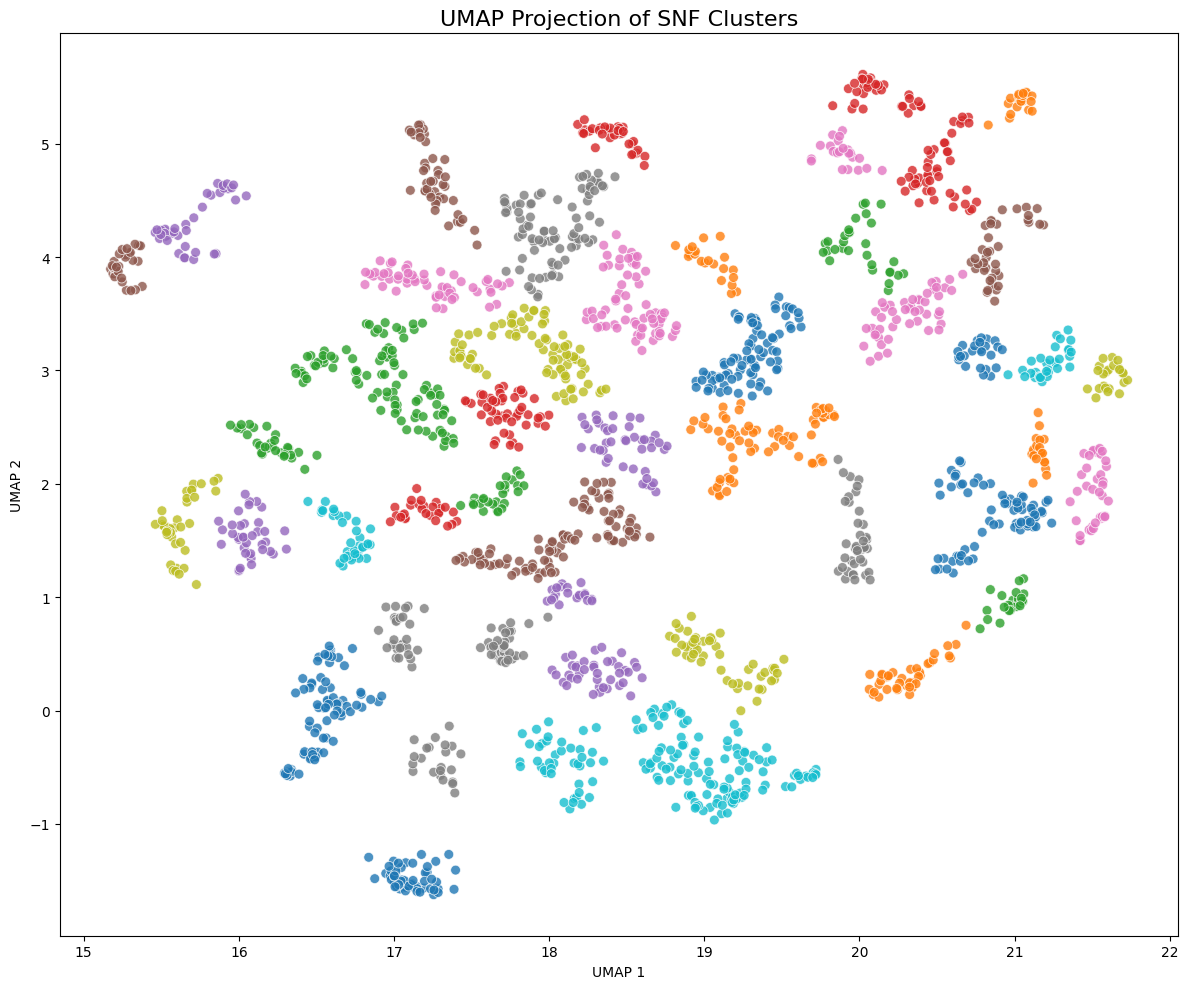

In [18]:
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)
plt.title("UMAP Projection of SNF Clusters", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [19]:
risultati_puliti.to_csv("snf_clusters_results.csv", index=False)

Centroids of each cluster:
    Cluster      UMAP1     UMAP2
0         0  17.099262 -1.482042
1         1  20.308882  0.306716
2         2  20.975075  0.950523
3         3  20.101336  5.473134
4         4  15.716038  4.328093
5         5  15.254506  3.919934
6         6  19.890856  4.912796
7         7  17.281647 -0.444024
8         8  15.620804  1.626967
9         9  18.084599 -0.466412
10       10  16.538948 -0.028346
11       11  21.036835  5.375158
12       12  16.202570  2.351113
13       13  18.410109  5.065567
14       14  16.066952  1.531269
15       15  17.256376  4.712834
16       16  21.510998  1.932360
17       17  17.044491  0.669953
18       18  19.104435  0.461049
19       19  19.068155 -0.513039
20       20  20.874310  1.712449
21       21  21.158117  2.285017
22       22  20.009436  4.091763
23       23  20.510679  4.765066
24       24  18.308077  0.335074
25       25  20.892380  4.057312
26       26  20.315897  3.496751
27       27  17.711214  0.574718
28       28  21.

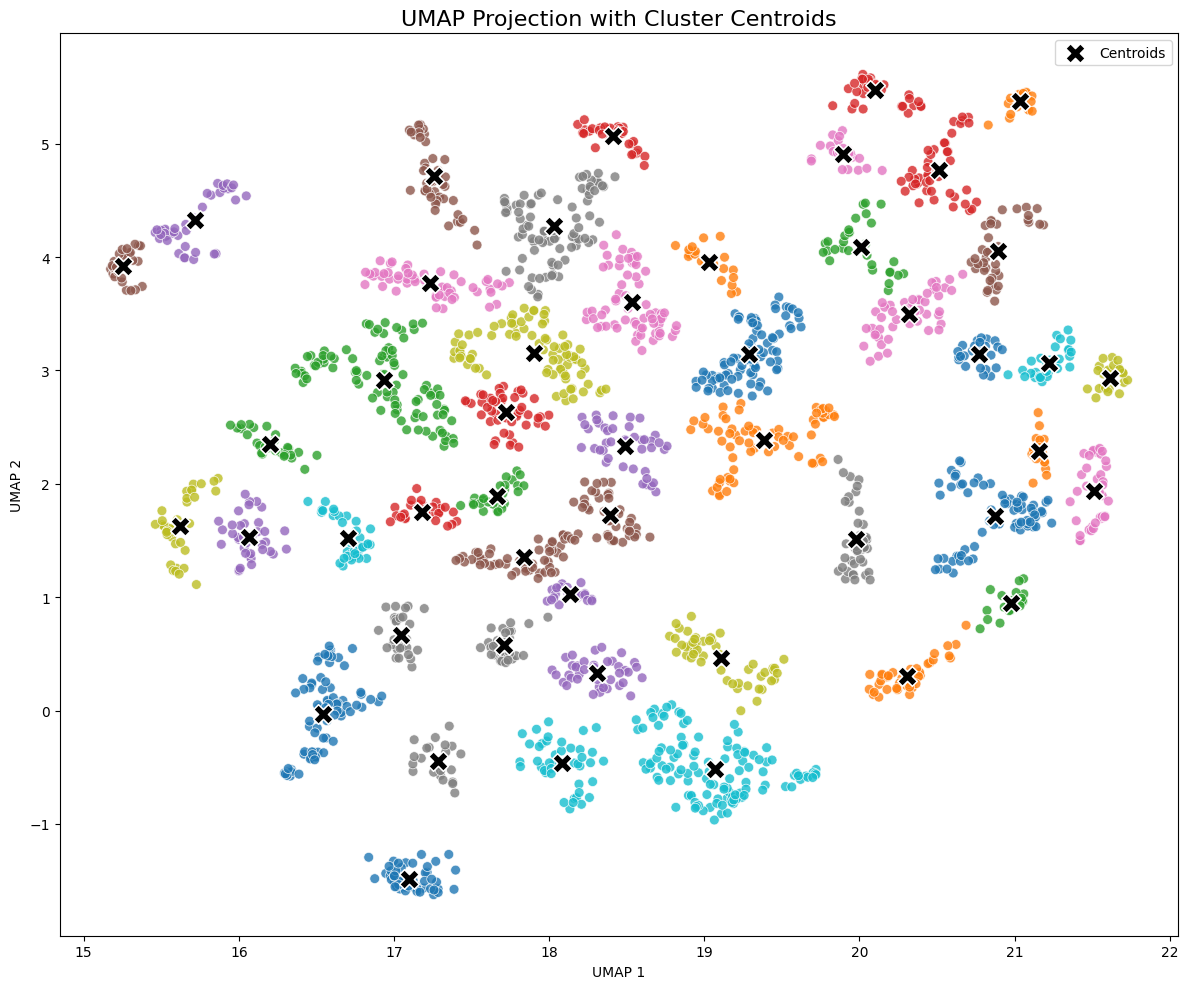

In [22]:
# Find centroids of each cluster
def find_cluster_centroids(results_df):
    centroids = results_df.groupby('Cluster')[['UMAP1', 'UMAP2']].mean().reset_index()
    return centroids
centroids = find_cluster_centroids(risultati_puliti)
print(f"Centroids of each cluster:\n{centroids}")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)

# Plot centroids
sns.scatterplot(
    data=centroids,
    x='UMAP1', 
    y='UMAP2',
    color='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title("UMAP Projection with Cluster Centroids", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [23]:
# Find the three closest genes to each centroid
def find_closest_genes_to_centroids(results_df, centroids, n_closest=3):
    closest_genes = {}
    
    for _, centroid in centroids.iterrows():
        cluster_id = centroid['Cluster']
        cluster_data = results_df[results_df['Cluster'] == cluster_id]
        
        # Calculate distances from centroid
        distances = np.sqrt(
            (cluster_data['UMAP1'] - centroid['UMAP1']) ** 2 + 
            (cluster_data['UMAP2'] - centroid['UMAP2']) ** 2
        )
        
        # Get the indices of the n_closest genes
        closest_indices = distances.nsmallest(n_closest).index
        
        closest_genes[cluster_id] = cluster_data.loc[closest_indices, 'Gene'].tolist()
    
    return closest_genes
closest_genes = find_closest_genes_to_centroids(risultati_puliti, centroids, n_closest=3)
print("Closest genes to each centroid:")
for cluster, genes in closest_genes.items():
    print(f"Cluster {cluster}: {genes}")

Closest genes to each centroid:
Cluster 0.0: [4723, 4713, 4539]
Cluster 1.0: [4677, 3028, 55157]
Cluster 2.0: [3921, 6138, 6132]
Cluster 3.0: [5309, 4774, 6664]
Cluster 4.0: [10021, 610, 10142]
Cluster 5.0: [3764, 169522, 1804]
Cluster 6.0: [50674, 6591, 220202]
Cluster 7.0: [249, 80025, 26007]
Cluster 8.0: [54977, 6569, 6523]
Cluster 9.0: [1586, 5447, 1588]
Cluster 10.0: [2218, 166929, 2651]
Cluster 11.0: [7552, 6928, 11281]
Cluster 12.0: [540, 6556, 4891]
Cluster 13.0: [7137, 4633, 4604]
Cluster 14.0: [254428, 56606, 3248]
Cluster 15.0: [5148, 6094, 54112]
Cluster 16.0: [7298, 55651, 5073]
Cluster 17.0: [54681, 112817, 652]
Cluster 18.0: [3251, 1807, 229]
Cluster 19.0: [5106, 2746, 3033]
Cluster 20.0: [23013, 8449, 8087]
Cluster 21.0: [104, 103, 114803]
Cluster 22.0: [6949, 3670, 50943]
Cluster 23.0: [64321, 2296, 145258]
Cluster 24.0: [285848, 57104, 63924]
Cluster 25.0: [8284, 10765, 84181]
Cluster 26.0: [8260, 51111, 6884]
Cluster 27.0: [4668, 4069, 3423]
Cluster 28.0: [5426, 990,

In [ ]:
import requests
import pandas as pd

def get_gene_names_from_api(gene_list):
    """
    Interroga MyGene.info per ottenere i nomi dei geni da una lista di ID.
    """
    url = "https://mygene.info/v3/query"
    
    # Parametri per la ricerca
    params = {
        'q': ",".join([str(g) for g in gene_list]), # Unisce gli ID con virgole
        'scopes': 'entrezgene,ensembl.gene,symbol,alias', # Dove cercare (ID numerici, Ensembl, o nomi)
        'fields': 'symbol,name', # Cosa vogliamo ottenere indietro
        'species': 'human' # Modifica se stai lavorando con topo ('mouse') o altro
    }
    
    # Facciamo una richiesta POST perché la lista di geni potrebbe essere lunga
    headers = {'content-type': 'application/x-www-form-urlencoded'}
    response = requests.post(url, data=params, headers=headers)
    
    if response.ok:
        return response.json()
    else:
        print(f"Errore API: {response.status_code}")
        return []

all_gene_ids = []
for genes in closest_genes.values():
    all_gene_ids.extend(genes)

unique_gene_ids = list(set(all_gene_ids))

# 2. Chiama l'API
print("Sto interrogando MyGene.info...")
api_results = get_gene_names_from_api(unique_gene_ids)

gene_info_map = {}
for item in api_results:
    query_id = item.get('query')
    symbol = item.get('symbol', 'N/A')
    name = item.get('name', 'Descrizione non disponibile')
    
    gene_info_map[query_id] = f"{symbol}: {name}"

for cluster, genes in closest_genes.items():
    print(f"\nCluster {cluster}:")
    for gene_id in genes:
        # Recupera il nome dal dizionario, se non c'è usa l'ID originale
        description = gene_info_map.get(str(gene_id), "Nessun dato trovato su MyGene")
        print(f"  • ID {gene_id} -> {description}")

Sto interrogando MyGene.info...

=== RISULTATI DETTAGLIATI ===

Cluster 0.0:
  • ID 4723 -> NDUFV1: NADH:ubiquinone oxidoreductase core subunit V1
  • ID 4713 -> NDUFB7: NADH:ubiquinone oxidoreductase subunit B7
  • ID 4539 -> MT-ND4L: NADH dehydrogenase subunit 4L

Cluster 1.0:
  • ID 4677 -> NARS1: asparaginyl-tRNA synthetase 1
  • ID 3028 -> HSD17B10: hydroxysteroid 17-beta dehydrogenase 10
  • ID 55157 -> DARS2: aspartyl-tRNA synthetase 2, mitochondrial

Cluster 2.0:
  • ID 3921 -> RPSA: ribosomal protein SA
  • ID 6138 -> RPL15: ribosomal protein L15
  • ID 6132 -> RPL8: ribosomal protein L8

Cluster 3.0:
  • ID 5309 -> PITX3: paired like homeodomain 3
  • ID 4774 -> NFIA: nuclear factor I A
  • ID 6664 -> SOX11: SRY-box transcription factor 11

Cluster 4.0:
  • ID 10021 -> HCN4: hyperpolarization activated cyclic nucleotide gated potassium channel 4
  • ID 610 -> HCN2: hyperpolarization activated cyclic nucleotide gated potassium and sodium channel 2
  • ID 10142 -> AKAP9: A-kina

In [ ]:
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt

def get_clean_symbols(gene_ids, info_map):
    symbols = []
    for gid in gene_ids:
        # Recupera la stringa "SIMBOLO: Nome"
        full_desc = info_map.get(str(gid), "")
        if ":" in full_desc:
            # Prende solo la parte prima dei due punti
            symbol = full_desc.split(":")[0].strip()
            symbols.append(symbol)
    return symbols

gsea_results = []

print("Esecuzione GSEA sui cluster in corso...")

# Ciclo su ogni cluster
for cluster_id, gene_ids in closest_genes.items():
    
    # 1. Ottieni i simboli dei geni puliti (es. ['NDUFV1', 'NDUFB7', ...])
    gene_list = get_clean_symbols(gene_ids, gene_info_map)
    
    # Se non abbiamo abbastanza geni riconosciuti, saltiamo
    if len(gene_list) < 2:
        gsea_results.append({
            'Cluster': cluster_id,
            'Top_Term': "Dati insufficienti",
            'P-value': 1.0,
            'Genes': ", ".join(gene_list)
        })
        continue

    try:
        # 2. Lancia l'analisi di arricchimento (Enrichr API)
        # Usiamo 'GO_Biological_Process_2023' e 'Reactome_2022'
        enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets=['GO_Biological_Process_2023', 'Reactome_2022'],
            organism='Human', 
            outdir=None  # Non salvare file su disco per ora
        )
        
        # 3. Prendi il risultato migliore (se esiste)
        results_df = enr.results
        if not results_df.empty:
            # Ordina per P-value (più basso è, più è significativo)
            top_res = results_df.sort_values('Adjusted P-value').iloc[0]
            
            term_name = top_res['Term']
            p_val = top_res['Adjusted P-value']
            
            gsea_results.append({
                'Cluster': cluster_id,
                'Top_Term': term_name,
                'P-value': p_val,
                'Genes': ", ".join(gene_list)
            })
        else:
            gsea_results.append({
                'Cluster': cluster_id,
                'Top_Term': "Nessun pathway significativo trovato",
                'P-value': 1.0,
                'Genes': ", ".join(gene_list)
            })
            
    except Exception as e:
        print(f"Errore nel cluster {cluster_id}: {e}")

df_gsea = pd.DataFrame(gsea_results)
df_gsea = df_gsea.sort_values('Cluster')

# Mostra i risultati
print("\n=== RISULTATI GSEA (Analisi di Arricchimento) ===")
pd.set_option('display.max_colwidth', None)
print(df_gsea[['Cluster', 'Top_Term', 'P-value']])

Esecuzione GSEA sui cluster in corso...

=== RISULTATI GSEA (Analisi di Arricchimento) ===
    Cluster  \
0       0.0   
1       1.0   
2       2.0   
3       3.0   
4       4.0   
5       5.0   
6       6.0   
7       7.0   
8       8.0   
9       9.0   
10     10.0   
11     11.0   
12     12.0   
13     13.0   
14     14.0   
15     15.0   
16     16.0   
17     17.0   
18     18.0   
19     19.0   
20     20.0   
21     21.0   
22     22.0   
23     23.0   
24     24.0   
25     25.0   
26     26.0   
27     27.0   
28     28.0   
29     29.0   
30     30.0   
31     31.0   
32     32.0   
33     33.0   
34     34.0   
35     35.0   
36     36.0   
37     37.0   
38     38.0   
39     39.0   
40     40.0   
41     41.0   
42     42.0   
43     43.0   
44     44.0   
45     45.0   
46     46.0   
47     47.0   

                                                                                         Top_Term  \
0                                                              Complex I

In [28]:
df_gsea.to_csv("gsea_cluster_results.csv", index=False)

In [33]:
import mofax
import pandas as pd

# Specifica il percorso del file
path_to_model = "mofa_model_final.hdf5"

print(f"Caricamento modello con mofax da: {path_to_model}...")

# 1. Carica il modello
# mofax.mofa_model legge automaticamente la struttura HDF5
model = mofax.mofa_model(path_to_model)

print("Modello caricato con successo!")
print(f"Dimensioni modello: {model.shape} (Campioni, Features)")

# 2. Estrai i Fattori Latenti (Z)
# Restituisce direttamente un DataFrame con i nomi dei campioni come indice
df_factors = model.get_factors(df=True)

# Rinomina le colonne per chiarezza (opzionale, di solito sono Factor1, Factor2...)
# mofax le chiama 0, 1, 2... di default se non specificato diversamente
df_factors.columns = [f"Factor{i+1}" for i in range(df_factors.shape[1])]

print("\n=== Fattori Latenti Estratti (Anteprima) ===")
print(df_factors.head())

# 3. Salva su CSV
output_filename = "mofa_factors_mofax.csv"
df_factors.to_csv(output_filename)
print(f"\nFattori salvati in: {output_filename}")

# --- BONUS: Estrai la Varianza Spiegata (R2) ---
# È utile per capire quale vista (omics) sta guidando ogni fattore
r2 = model.get_r2()
print("\n=== Varianza Spiegata (R2) ===")
print(r2.head())
df_factors

Caricamento modello con mofax da: mofa_model_final.hdf5...
Modello caricato con successo!
Dimensioni modello: (3317, 12217) (Campioni, Features)

=== Fattori Latenti Estratti (Anteprima) ===
                 Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
sample0_group0 -0.260752  0.010653 -0.564061  0.020650  1.140270  0.313071   
sample1_group0 -0.412162 -0.060641 -0.070670 -0.240767 -0.237747 -0.300807   
sample2_group0 -0.361772 -0.059856  0.692110 -0.028525 -0.557938 -0.265820   
sample3_group0 -0.350291 -0.068715  1.255194 -0.128189 -0.534190 -0.204384   
sample4_group0 -0.353276 -0.025950  0.741029 -0.448676 -0.619889 -0.373601   

                 Factor7   Factor8   Factor9  Factor10  
sample0_group0  4.048909  1.612207  0.444203       0.0  
sample1_group0  1.077942 -0.425312 -0.450232       0.0  
sample2_group0 -0.260779  0.772818  0.358611       0.0  
sample3_group0 -0.287136 -0.395647 -0.589582       0.0  
sample4_group0 -0.397500  0.411423 -0.026400       0.0 

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10
sample0_group0,-0.260752,0.010653,-0.564061,0.020650,1.140270,0.313071,4.048909,1.612207,0.444203,0.0
sample1_group0,-0.412162,-0.060641,-0.070670,-0.240767,-0.237747,-0.300807,1.077942,-0.425312,-0.450232,0.0
sample2_group0,-0.361772,-0.059856,0.692110,-0.028525,-0.557938,-0.265820,-0.260779,0.772818,0.358611,0.0
sample3_group0,-0.350291,-0.068715,1.255194,-0.128189,-0.534190,-0.204384,-0.287136,-0.395647,-0.589582,0.0
sample4_group0,-0.353276,-0.025950,0.741029,-0.448676,-0.619889,-0.373601,-0.397500,0.411423,-0.026400,0.0
...,...,...,...,...,...,...,...,...,...,...
sample3312_group0,-0.397785,-0.057489,0.374927,0.724097,-0.632105,-0.247238,-0.517324,-0.413952,-0.576169,0.0
sample3313_group0,-0.350125,-0.073717,-0.219335,-0.690603,-0.551356,-0.228552,-0.310313,-0.390802,-0.385835,0.0
sample3314_group0,-0.395986,-0.074245,-0.340666,-0.443192,-0.559376,-0.212846,-0.567426,-0.300274,-0.607971,0.0
sample3315_group0,-0.419092,-0.086865,-0.165969,-0.660072,-0.555417,-0.209676,-0.085109,1.396091,0.054081,0.0


In [ ]:
import pandas as pd

df_original = pd.read_csv("filtered_final_BP.csv", index_col=0)
geni_names = df_original.index

print(f"Righe nel modello: {len(df_factors)}")
print(f"Righe nel file originale: {len(geni_names)}")

# 3. Controllo di sicurezza: Le lunghezze DEVONO coincidere
if len(df_factors) == len(geni_names):
    # SOVRASCRIVI l'indice brutto con i tuoi nomi ENSG
    df_factors.index = geni_names
    
    # Ora df_factors ha i nomi giusti
    print("\n✅ Nomi corretti assegnati! Ecco le prime righe:")
    print(df_factors.head())
    
    # Salva di nuovo il file corretto
    df_factors.to_csv("mofa_factors_con_nomi_geni.csv")
else:
    print("⚠️ ATTENZIONE: Il numero di righe non corrisponde! Qualcosa non va.")

Righe nel modello: 3317
Righe nel file originale: 3317

✅ Nomi corretti assegnati! Ecco le prime righe:
     Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
16 -0.260752  0.010653 -0.564061  0.020650  1.140270  0.313071  4.048909   
18 -0.412162 -0.060641 -0.070670 -0.240767 -0.237747 -0.300807  1.077942   
19 -0.361772 -0.059856  0.692110 -0.028525 -0.557938 -0.265820 -0.260779   
20 -0.350291 -0.068715  1.255194 -0.128189 -0.534190 -0.204384 -0.287136   
21 -0.353276 -0.025950  0.741029 -0.448676 -0.619889 -0.373601 -0.397500   

     Factor8   Factor9  Factor10  
16  1.612207  0.444203       0.0  
18 -0.425312 -0.450232       0.0  
19  0.772818  0.358611       0.0  
20 -0.395647 -0.589582       0.0  
21  0.411423 -0.026400       0.0  


In [38]:
geni_con_factors = pd.read_csv("mofa_factors_con_nomi_geni.csv", index_col=0)

   Dati pronti: (3317, 10) geni.
   Esecuzione UMAP...


C:\Users\nicki\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   Esecuzione HDBSCAN (min_cluster_size=20)...
   -> Trovati 37 cluster. (Geni 'Noise': 445)


C:\Users\nicki\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nicki\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


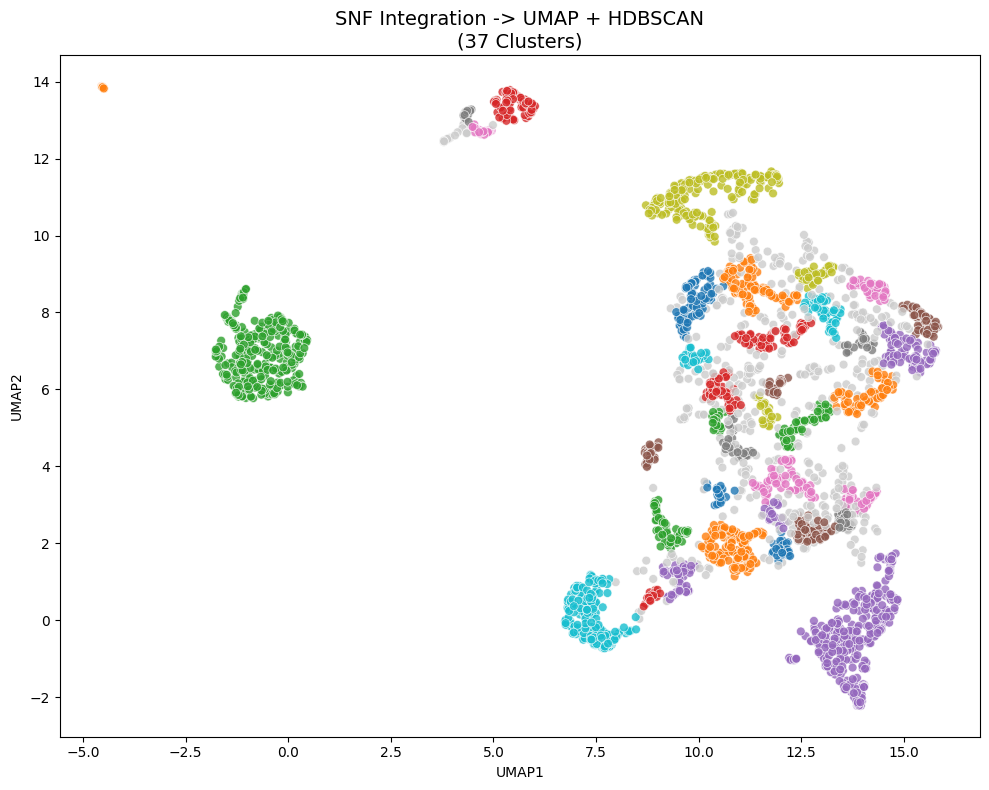

In [ ]:
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import os

def visualize_mofa_clustering(fused_matrix_path, min_cluster_size=15):
    
    # A. Caricamento
    if not os.path.exists(fused_matrix_path):
        print("Errore: File non trovato.")
        return
    
    df_fused = pd.read_csv(fused_matrix_path, index_col=0)
    W = df_fused.values # Matrice di Similarità (0 a 1 solitamente)

    distance_matrix = W
    
    print(f"   Dati pronti: {distance_matrix.shape} geni.")

    # C. UMAP
    # metric='precomputed' è FONDAMENTALE perché passiamo una matrice di distanze,
    # non la tabella originale dei dati.
    print("   Esecuzione UMAP...")
    reducer = umap.UMAP(
        metric='cosine',
        n_neighbors=20,
        min_dist=0.1,
        n_components=2,
        random_state=42
    )
    embedding = reducer.fit_transform(distance_matrix)
    
    # D. HDBSCAN
    # Eseguiamo il clustering sulle coordinate UMAP (metodo comune per visualizzazione coerente)
    print(f"   Esecuzione HDBSCAN (min_cluster_size={min_cluster_size})...")
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,        # Quanto conservativo deve essere (più alto = più noise/grigio)
        metric='euclidean'    # Qui usiamo euclidea perché lavoriamo sulle coordinate 2D di UMAP
    )
    cluster_labels = clusterer.fit_predict(embedding)
    
    # Statistiche
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    print(f"   -> Trovati {n_clusters} cluster. (Geni 'Noise': {n_noise})")

    # E. Plotting
    plt.figure(figsize=(10, 8))
    
    # Creiamo un DataFrame temporaneo per il plot
    plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    plot_df['Cluster'] = cluster_labels
    plot_df['Cluster'] = plot_df['Cluster'].astype(str) # Per colori categorici
    
    # Gestione colori: il cluster -1 è "Noise" (rumore), lo coloriamo di grigio
    unique_labels = sorted(plot_df['Cluster'].unique(), key=lambda x: int(x))
    palette = sns.color_palette("tab10", len(unique_labels))
    color_map = dict(zip(unique_labels, palette))
    if '-1' in color_map:
        color_map['-1'] = (0.8, 0.8, 0.8) # Grigio chiaro per noise
        
    sns.scatterplot(
        data=plot_df,
        x='UMAP1', y='UMAP2',
        hue='Cluster',
        palette=color_map,
        s=40,
        alpha=0.8,
        legend=False
    )
    
    plt.title(f"SNF Integration -> UMAP + HDBSCAN\n({n_clusters} Clusters)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # F. Salvataggio risultati
    df_results = pd.DataFrame({
        'Gene': df_fused.index,
        'Cluster': cluster_labels,
        'UMAP1': embedding[:, 0],
        'UMAP2': embedding[:, 1]
    })
    
    return df_results

# Esempio di utilizzo:
risultati = visualize_mofa_clustering("mofa_factors_con_nomi_geni.csv", min_cluster_size=20)

In [3]:
risultati_puliti_2 = risultati[risultati['Cluster'] != -1]

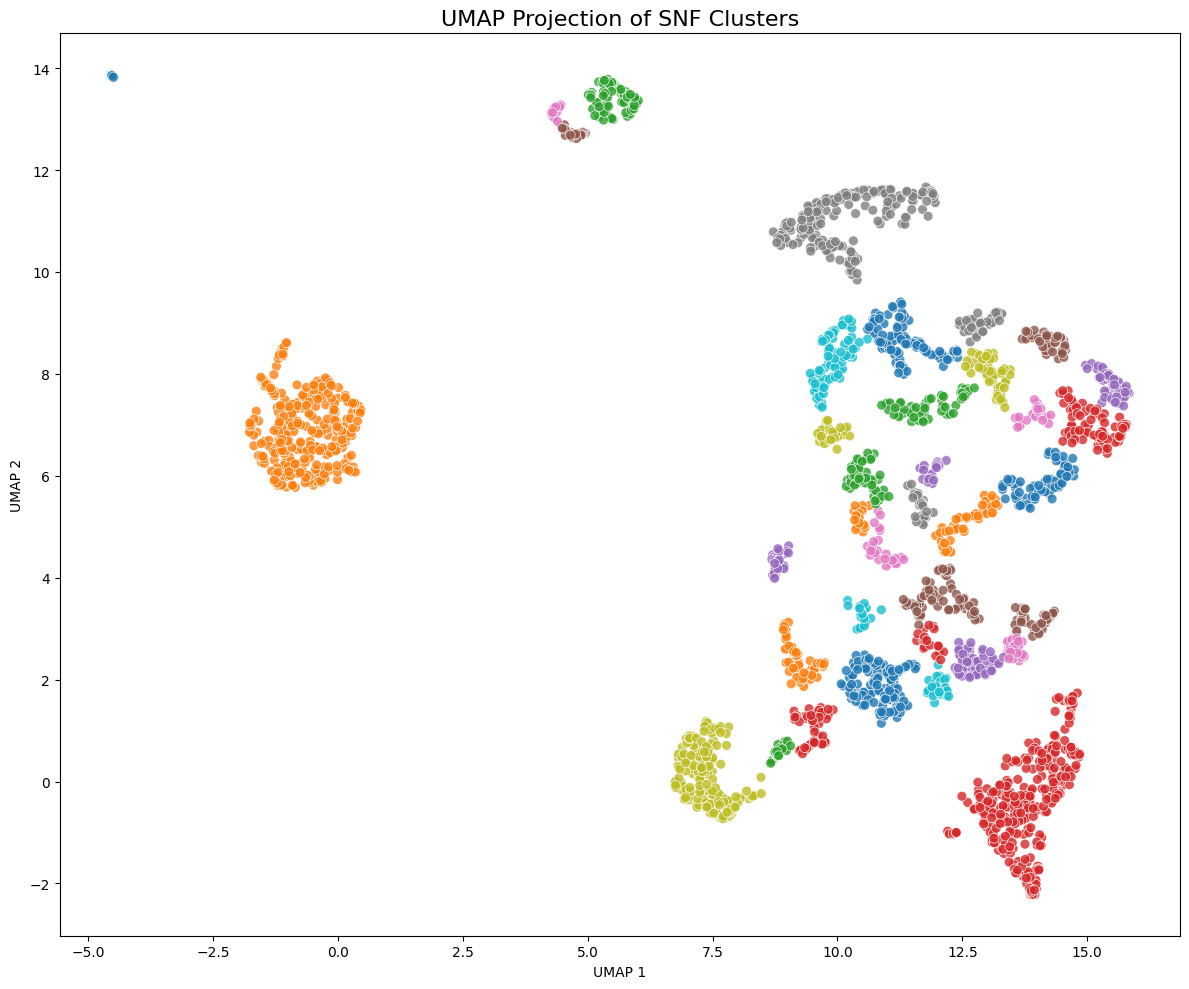

In [4]:
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti_2,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)
plt.title("UMAP Projection of SNF Clusters", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

Centroids of each cluster:
    Cluster      UMAP1      UMAP2
0         0  -4.524737  13.850970
1         1  -0.686213   6.964214
2         2   5.538548  13.421081
3         3  13.792291  -0.411356
4         4   8.805635   4.276204
5         5   4.687839  12.728481
6         6   4.352270  13.154545
7         7  10.211041  11.069468
8         8   7.386486   0.100686
9         9  10.495191   3.275761
10       10  10.834652   1.834189
11       11   9.246409   2.387061
12       12   8.834765   0.585039
13       13   9.515751   1.060848
14       14  11.897387   6.076430
15       15  14.258795   8.615013
16       16  13.954271   7.209864
17       17  11.651320   5.399575
18       18   9.880695   6.824586
19       19  12.037257   1.851173
20       20  14.106966   5.861799
21       21  12.608484   5.096702
22       22  11.749017   7.357484
23       23  15.093703   6.974569
24       24  15.495713   7.783126
25       25  12.060625   3.590226
26       26  10.936425   4.548491
27       27  12.84528

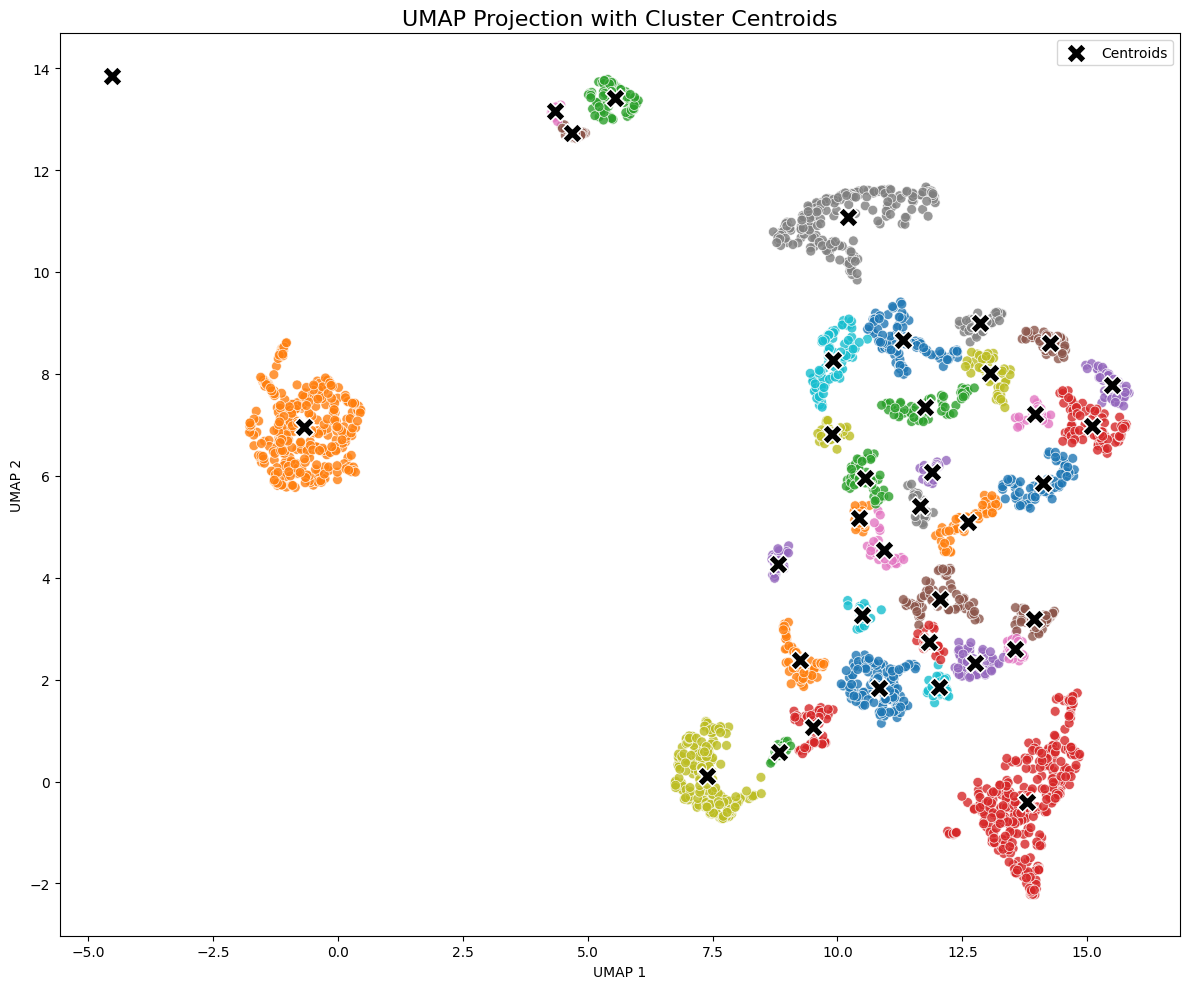

In [5]:
# Find centroids of each cluster
def find_cluster_centroids(results_df):
    centroids = results_df.groupby('Cluster')[['UMAP1', 'UMAP2']].mean().reset_index()
    return centroids
centroids = find_cluster_centroids(risultati_puliti_2)
print(f"Centroids of each cluster:\n{centroids}")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=risultati_puliti_2,
    x='UMAP1', 
    y='UMAP2',
    hue='Cluster',
    palette="tab10",
    s=50,
    alpha=0.8,
    legend=False
)

# Plot centroids
sns.scatterplot(
    data=centroids,
    x='UMAP1', 
    y='UMAP2',
    color='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title("UMAP Projection with Cluster Centroids", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [6]:
# Find the three closest genes to each centroid
def find_closest_genes_to_centroids(results_df, centroids, n_closest=3):
    closest_genes = {}
    
    for _, centroid in centroids.iterrows():
        cluster_id = centroid['Cluster']
        cluster_data = results_df[results_df['Cluster'] == cluster_id]
        
        # Calculate distances from centroid
        distances = np.sqrt(
            (cluster_data['UMAP1'] - centroid['UMAP1']) ** 2 + 
            (cluster_data['UMAP2'] - centroid['UMAP2']) ** 2
        )
        
        # Get the indices of the n_closest genes
        closest_indices = distances.nsmallest(n_closest).index
        
        closest_genes[cluster_id] = cluster_data.loc[closest_indices, 'Gene'].tolist()
    
    return closest_genes
closest_genes = find_closest_genes_to_centroids(risultati_puliti_2, centroids, n_closest=3)
print("Closest genes to each centroid:")
for cluster, genes in closest_genes.items():
    print(f"Cluster {cluster}: {genes}")

Closest genes to each centroid:
Cluster 0.0: [2201, 444, 6497]
Cluster 1.0: [6913, 10293, 81620]
Cluster 2.0: [85378, 10518, 1261]
Cluster 3.0: [4659, 1131, 1642]
Cluster 4.0: [4952, 4854, 6804]
Cluster 5.0: [4990, 7439, 145226]
Cluster 6.0: [8842, 5148, 6094]
Cluster 7.0: [147912, 29128, 2353]
Cluster 8.0: [4618, 2617, 1959]
Cluster 9.0: [51704, 23236, 2896]
Cluster 10.0: [7337, 2917, 57465]
Cluster 11.0: [103, 7466, 4191]
Cluster 12.0: [56652, 1716, 9782]
Cluster 13.0: [23259, 25978, 81790]
Cluster 14.0: [7297, 5583, 3273]
Cluster 15.0: [11181, 9380, 1576]
Cluster 16.0: [826, 1438, 1439]
Cluster 17.0: [5962, 4909, 102]
Cluster 18.0: [5777, 567, 8737]
Cluster 19.0: [8604, 84706, 8496]
Cluster 20.0: [4153, 347688, 169026]
Cluster 21.0: [53904, 284382, 90167]
Cluster 22.0: [6288, 79092, 5873]
Cluster 23.0: [669, 7053, 1066]
Cluster 24.0: [2936, 387700, 771]
Cluster 25.0: [6900, 85300, 6844]
Cluster 26.0: [1000, 71, 10464]
Cluster 27.0: [63924, 10068, 2328]
Cluster 28.0: [6820, 970, 4023

In [7]:
import requests
import pandas as pd

def get_gene_names_from_api(gene_list):
    """
    Interroga MyGene.info per ottenere i nomi dei geni da una lista di ID.
    """
    url = "https://mygene.info/v3/query"
    
    # Parametri per la ricerca
    params = {
        'q': ",".join([str(g) for g in gene_list]), # Unisce gli ID con virgole
        'scopes': 'entrezgene,ensembl.gene,symbol,alias', # Dove cercare (ID numerici, Ensembl, o nomi)
        'fields': 'symbol,name', # Cosa vogliamo ottenere indietro
        'species': 'human' # Modifica se stai lavorando con topo ('mouse') o altro
    }
    
    # Facciamo una richiesta POST perché la lista di geni potrebbe essere lunga
    headers = {'content-type': 'application/x-www-form-urlencoded'}
    response = requests.post(url, data=params, headers=headers)
    
    if response.ok:
        return response.json()
    else:
        print(f"Errore API: {response.status_code}")
        return []

# 1. Estrai tutti gli ID unici dai tuoi risultati per fare una sola chiamata
all_gene_ids = []
for genes in closest_genes.values():
    all_gene_ids.extend(genes)

# Rimuovi duplicati (se un gene appare in più cluster)
unique_gene_ids = list(set(all_gene_ids))

# 2. Chiama l'API
print("Sto interrogando MyGene.info...")
api_results = get_gene_names_from_api(unique_gene_ids)

# 3. Crea un "dizionario di traduzione" (ID -> Nome Reale)
gene_info_map = {}
for item in api_results:
    query_id = item.get('query') # L'ID che abbiamo chiesto noi
    symbol = item.get('symbol', 'N/A')
    name = item.get('name', 'Descrizione non disponibile')
    
    # Salviamo nel formato: "SIMBOLO: Nome completo"
    gene_info_map[query_id] = f"{symbol}: {name}"

# 4. Stampa i risultati finali leggibili
print("\n=== RISULTATI DETTAGLIATI ===")
for cluster, genes in closest_genes.items():
    print(f"\nCluster {cluster}:")
    for gene_id in genes:
        # Recupera il nome dal dizionario, se non c'è usa l'ID originale
        description = gene_info_map.get(str(gene_id), "Nessun dato trovato su MyGene")
        print(f"  • ID {gene_id} -> {description}")

Sto interrogando MyGene.info...

=== RISULTATI DETTAGLIATI ===

Cluster 0.0:
  • ID 2201 -> FBN2: fibrillin 2
  • ID 444 -> ASPH: aspartate beta-hydroxylase
  • ID 6497 -> SKI: SKI proto-oncogene

Cluster 1.0:
  • ID 6913 -> TBX15: T-box transcription factor 15
  • ID 10293 -> TRAIP: TRAF interacting protein
  • ID 81620 -> CDT1: chromatin licensing and DNA replication factor 1

Cluster 2.0:
  • ID 85378 -> TUBGCP6: tubulin gamma complex component 6
  • ID 10518 -> CIB2: calcium and integrin binding family member 2
  • ID 1261 -> CNGA3: cyclic nucleotide gated channel subunit alpha 3

Cluster 3.0:
  • ID 4659 -> PPP1R12A: protein phosphatase 1 regulatory subunit 12A
  • ID 1131 -> CHRM3: cholinergic receptor muscarinic 3
  • ID 1642 -> DDB1: damage specific DNA binding protein 1

Cluster 4.0:
  • ID 4952 -> OCRL: OCRL inositol polyphosphate-5-phosphatase
  • ID 4854 -> NOTCH3: notch receptor 3
  • ID 6804 -> STX1A: syntaxin 1A

Cluster 5.0:
  • ID 4990 -> SIX6: SIX homeobox 6
  • ID 74

In [ ]:
# Estrai i pesi (Weights)
# views=0 prende la prima vista (es. RNA/mRNA), se ne hai più di una specifica l'indice o il nome
df_weights = model.get_weights(views=0, df=True) 

df_weights


=== Pesi dei Geni (Weights) ===


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10
feature0_view0,-3.151795e-07,-4.113655e-08,-3.089357e-05,-0.000051,2.289197e-06,-8.191885e-07,1.631892e-06,2.514747e-07,-7.083638e-07,0.0
feature1_view0,-5.257515e-07,-1.156430e-07,-6.560482e-05,-0.000112,-2.678259e-06,-2.856957e-06,7.128956e-06,1.611739e-06,-1.801177e-06,0.0
feature2_view0,-5.266455e-07,-2.686238e-08,4.053711e-04,0.086986,1.205545e-05,9.220658e-07,2.041407e-05,1.738275e-06,4.312866e-06,0.0
feature3_view0,-4.727376e-07,7.671341e-07,9.540766e-05,0.000121,-4.083408e-06,1.867138e-06,3.942544e-06,9.735885e-07,-8.388775e-07,0.0
feature4_view0,-4.963680e-08,1.812489e-06,2.127957e-04,0.006829,1.464922e-05,-6.428560e-06,1.051210e-05,4.284241e-06,5.711503e-06,0.0
...,...,...,...,...,...,...,...,...,...,...
feature4802_view0,2.537704e-07,-4.133423e-08,2.591700e-06,0.000054,-5.376656e-07,-8.222347e-07,-3.174439e-07,-1.676947e-07,9.946169e-07,0.0
feature4803_view0,-2.282431e-07,-8.440808e-08,-6.446885e-05,-0.000063,-2.329072e-06,1.214694e-06,1.562709e-06,8.239642e-08,1.267786e-07,0.0
feature4804_view0,-2.270208e-07,-2.413824e-08,-8.462280e-07,-0.000038,-2.896156e-06,-3.124979e-08,-4.215233e-07,-5.182909e-07,-1.949800e-07,0.0
feature4805_view0,-2.938142e-08,-4.598552e-09,-4.103151e-06,0.000004,-3.615548e-07,-1.733002e-07,-1.221262e-07,-8.431595e-08,-8.461096e-08,0.0


### Analisi dei Risultati (Fase 6.A)
#### 1. Cluster 0: Il "Cluster Immunitario"
* **Top Pathway:** MHC Class II Antigen Presentation

* **Significatività (FDR):** $3.6 \times 10^{-5}$ (Molto alta)

* **Interpretazione:** Questo cluster raggruppa geni coinvolti nella risposta immunitaria adattativa. La presentazione dell'antigene tramite MHC di classe II è il meccanismo fondamentale con cui le cellule immunitarie (come macrofagi e cellule dendritiche) "mostrano" i patogeni ai linfociti T per attivare la difesa.

* **Conclusione:** Hai isolato con successo una componente immunologica distinta nel tuo dataset.

#### 2. Cluster 1: Il "Cluster di Segnalazione Wnt"

* **Top Pathway:** Disassembly Of Destruction Complex And Recruitment Of AXIN To Membrane

* **Significatività (FDR):** $1.8 \times 10^{-3}$

* **Interpretazione:** Questo è un risultato molto specifico e raffinato. Si riferisce alla via di segnalazione **Wnt/Beta-catenina.** Il "complesso di distruzione" (che include geni come DVL3 che hai nell'esempio) regola la proliferazione cellulare e il differenziamento. Quando questo complesso viene smantellato, la cellula riceve il segnale di crescere o dividersi.

* **Conclusione:** Questo cluster rappresenta processi di sviluppo cellulare e proliferazione.

#### 3. Cluster 2: Cluster del Metabolismo Centrale e Risposta Infettiva

* **Top Pathway (Generale):** *Disease*

* **Pathway Specifici (Driver):** *Metabolism*, *Metabolism of proteins*, *Infectious disease*, *Viral mRNA Translation*.

* **Significatività (FDR):** $1.8 \times 10^{-12}$ (Estremamente alta).

* **Dimensione:** 763 geni (Cluster maggioritario).

**Interpretazione Biologica:**
Sebbene il termine "Disease" appaia come risultato principale a causa della sua natura macroscopica, l'analisi dei pathway successivi rivela l'identità funzionale precisa di questo cluster.

I geni qui raggruppati dominano le funzioni di **metabolismo cellulare** e **metabolismo delle proteine** (sintesi e gestione proteica). La forte associazione con pathway quali *Infectious disease* e *Viral mRNA Translation* suggerisce che questo cluster rappresenta il **macchinario cellulare "Housekeeping"**: si tratta di componenti essenziali del "motore" della cellula (come la traduzione dell'mRNA e la trascrizione genica) che vengono tipicamente dirottati dai virus durante le infezioni o alterati sistemicamente in condizioni di stress metabolico. Non indica una singola malattia, ma il core funzionale che viene perturbato in molteplici stati patologici.